# Самостоятельный проект. Обучение с учителем: качество модели

**Описание проекта:** \
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. \
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. \
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

**Задачи исследования:**
- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
    - Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Основные этапы работы:**
- Загрузка данных.
- Предобработка данных. Проверка на дубликаты и пропуски
- Исследовательский анализ данных. Устранение выбросов, добавление/изменение признаков. Создание портрета "уволившегося сотрудника".
- Подготовка данных. Настройка пайплайнов для кодирования и устранения пропусков.
- Обучение моделей. Создание финального пайплайна для подбора гиперпараметров для каждой модели. Использование метрики "SMAPE" для задачи регрессии, "ROC-AUC" - для задачи классификации.

**Общий вывод:**
- Для решения первой задачи подходит модель - `Ridge` с набором параметров \ ({'models__alpha': 1, 'preprocessor__num__scaler': StandardScaler()}).
- Для решения второй задачи подходит модель - `KNeighborsClassifier` с набором параметров \ ({'models__n_neighbors': 8, 'preprocessor__num': MinMaxScaler()}).
- Уровень `job_satisfaction_rate` остается разбросанным вне зависимости от количества лет в компании. Даже у сотрудников с 8–10 годами стажа встречаются низкие значения удовлетворённости, как и у новых сотрудников.
- Чем выше оценка качества работы, тем выше у сотрудника уровень его удовлетворенности в среднем.
- Низкие оценки руководителей (1–2) почти не приводят к высокой удовлетворенности. Почти отсутствуют крупные точки (высокая удовлетворенность) при низкой `supervisor_evaluation`. Это может говорить о демотивации в подразделениях, где оценивают низко.
- Во всех департаментах при одинаковой supervisor_evaluation наблюдаются схожие уровни `job_satisfaction_rate` — сильной зависимости от отдела нет.
- С увеличением зарплаты удовлетворенность работой растет, но эффект более выражен в отделах продаж и технологий.
- У сотрудников с высокой оценкой руководителя (4–5), но низким уровнем удовлетворённости (0–0.4) наблюдаются чаще нарушения (крестики). Это может говорить о скрытом напряжении: формально всё хорошо, но сотрудники не довольны, что проявляется в поведении.
- Большинство сотрудников, которые нарушали трудовой договор меньше удовлетворены работой, чем те кто не нарушал, даже вне зависимости от получаемой зарплаты.

**Дополнительные предложения для бизнеса:**
- Низкие оценки руководителей (1–2) почти не приводят к высокой удовлетворенности. Почти отсутствуют крупные точки (высокая удовлетворенность) при низкой `supervisor_evaluation`. Это может говорить о демотивации в подразделениях, где оценивают низко.
- Повышение позитивно влияет на уровень удовлетворенности. У тех кого повысили уровень `job_satisfaction_rate` выше, чем у остальных.
- Среди сотрудников, работающих недолго (1-3 года), те у кого высоко оценили качество работы, не хотят уходить. Возможно можно пересмотреть оценивание работников с небольшим опытом работы в компании.
- Уровень заработной платы влияет на уход сотрудника, в тех случаях когда он работал в компании меньше 6 лет. Те, кто работают больше, меньше задумываются об уходе. Оценка качества работы почти никак не влияет на то уйдет сотрудник или нет. Возможно стоит рассмотреть какие-нибудь бонусы для новых сотрудников.


In [1]:
!pip install -q phik
!pip install --upgrade -q scikit-learn

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from phik import phik_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [3]:
RANDOM_STATE = 42

## Задача №1

### Загрузка данных

In [4]:
def load_df(filename, sep=',', decimal='.'):
    pth1 = "./datasets/" + filename
    pth2 = 'https://code.s3.yandex.net/datasets/' + filename

    if os.path.exists(pth1):
        df = pd.read_csv(pth1, sep=sep, decimal=decimal)
    else:
        df = pd.read_csv(pth2, sep=sep, decimal=decimal)

    print('\n\tПервые строки датафрейма')
    display(df.head())

    print('\n\n\tИнформация о датафрейме\n')
    df.info()

    if not df.select_dtypes(exclude='object').empty:
        print('\n\n\tОписательная статистика о количественных признаках')
        display(df.describe().T)

    if not df.select_dtypes(include='object').empty:
        print('\n\n\tОписательная статистика о качественных признаках')
        display(df.describe(include='object').T)

    return df

In [5]:
X_train_sr = load_df('train_job_satisfaction_rate.csv')


	Первые строки датафрейма


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20



	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


	Описательная статистика о количественных признаках


count           mean            std        min  \
id                     4000.0  544957.621000  257883.104622  100954.00   
employment_years       4000.0       3.718500       2.542513       1.00   
supervisor_evaluation  4000.0       3.476500       1.008812       1.00   
salary                 4000.0   33926.700000   14900.703838   12000.00   
job_satisfaction_rate  4000.0       0.533995       0.225327       0.03   

                             25%        50%        75%       max  
id                     322836.75  534082.50  771446.00  999521.0  
employment_years            2.00       3.00       6.00      10.0  
supervisor_evaluation       3.00       4.00       4.00       5.0  
salary                  22800.00   30000.00   43200.00   98400.0  
job_satisfaction_rate       0.36       0.56       0.71       1.0



	Описательная статистика о качественных признаках


count unique     top  freq
dept                  3994      5   sales  1512
level                 3996      3  junior  1894
workload              4000      3  medium  2066
last_year_promo       4000      2      no  3880
last_year_violations  4000      2      no  3441

In [6]:
X_test_sr = load_df('test_features.csv')


	Первые строки датафрейма


id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800



	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


	Описательная статистика о количественных признаках


count         mean            std       min       25%  \
id                     2000.0  552765.2135  253851.326129  100298.0  339052.0   
employment_years       2000.0       3.6665       2.537222       1.0       1.0   
supervisor_evaluation  2000.0       3.5265       0.996892       1.0       3.0   
salary                 2000.0   34066.8000   15398.436729   12000.0   22800.0   

                            50%        75%       max  
id                     550793.0  765763.75  999029.0  
employment_years            3.0       6.00      10.0  
supervisor_evaluation       4.0       4.00       5.0  
salary                  30000.0   43200.00   96000.0



	Описательная статистика о качественных признаках


count unique     top  freq
dept                  1998      6   sales   763
level                 1999      3  junior   974
workload              2000      4  medium  1043
last_year_promo       2000      2      no  1937
last_year_violations  2000      2      no  1738

In [7]:
y_test_sr = load_df('test_target_job_satisfaction_rate.csv')


	Первые строки датафрейма


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08



	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


	Описательная статистика о количественных признаках


count          mean            std        min  \
id                     2000.0  552765.21350  253851.326129  100298.00   
job_satisfaction_rate  2000.0       0.54878       0.220110       0.03   

                             25%        50%        75%       max  
id                     339052.00  550793.00  765763.75  999029.0  
job_satisfaction_rate       0.38       0.58       0.72       1.0

**Выводы**

Данные загружены, есть пропуски.

### Предобработка данных

In [8]:
def check_dupl_nans(df):
    print('\n\tКоличество полных дубликатов =', df.duplicated().sum())

    columns = df.select_dtypes(include='object').columns.tolist()
    if len(columns) != 0:
        print('\n\tПоиск неявных дубликатов')
        for column in columns:
            print('В столбце', column, 'уникальных значений =', df[column].nunique())
            print('Список уникальных значений =', df[column].unique(), '\n')

    print('\n\tКоличество пропущенных значений')
    print(df.isna().sum())

    print('\n\tТипы данных')
    print(df.dtypes)

In [9]:
check_dupl_nans(X_train_sr)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце dept уникальных значений = 5
Список уникальных значений = ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

В столбце level уникальных значений = 3
Список уникальных значений = ['junior' 'middle' 'sinior' nan] 

В столбце workload уникальных значений = 3
Список уникальных значений = ['medium' 'high' 'low'] 

В столбце last_year_promo уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 

В столбце last_year_violations уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 


	Количество пропущенных значений
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

	Типы данных
id                         int64
dept                      object
level              

In [10]:
check_dupl_nans(X_test_sr)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце dept уникальных значений = 6
Список уникальных значений = ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

В столбце level уникальных значений = 3
Список уникальных значений = ['junior' 'middle' 'sinior' nan] 

В столбце workload уникальных значений = 4
Список уникальных значений = ['medium' 'low' 'high' ' '] 

В столбце last_year_promo уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 

В столбце last_year_violations уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 


	Количество пропущенных значений
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

	Типы данных
id                        int64
dept                     object
level                    object
workload

In [11]:
check_dupl_nans(y_test_sr)


	Количество полных дубликатов = 0

	Количество пропущенных значений
id                       0
job_satisfaction_rate    0
dtype: int64

	Типы данных
id                         int64
job_satisfaction_rate    float64
dtype: object


**Выводы**

- Пропущенные значения будут обработаны в пайплайне
- Полных дубликатов нет
- Неявных дубликатов нет

Следующий этап - исследовательский анализ данных


### Исследовательский анализ данных

In [12]:
sns.set_theme(style='whitegrid', palette='pastel')

In [13]:
def eda_describe_numeric(df, column, is_discrete=False):
    print(df[column].describe().T)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    if is_discrete:
        sns.countplot(x=column, data=df)
    else:
        sns.histplot(df[column], kde=True, bins=int(np.ceil(np.log2(df.shape[0]))))
    plt.title(f'Распределение {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами {column}')
    plt.show()

In [14]:
def eda_describe_categorical(df, column):
    print(df[column].describe(include='object').T)
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[column], order=df[column].value_counts().index)
    plt.title(f"Распределение {column}")
    plt.xticks(rotation=45)
    plt.show()

In [15]:
def eda_describe_feature(df, column, is_discrete=False):
    print('\n\tОписательная статистика столбца -', column)
    num_col_names = df.select_dtypes(include='number').columns.tolist()
    # для числовых переменных
    if column in num_col_names:
        eda_describe_numeric(df, column, is_discrete)

    # для категориальных переменных
    else:
        eda_describe_categorical(df, column)

#### `X_train_sr`

##### `dept`


	Описательная статистика столбца - dept
count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object


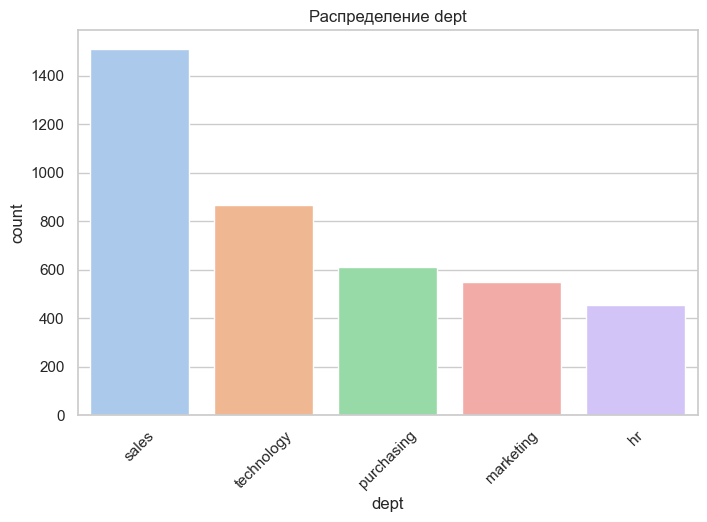

In [16]:
eda_describe_feature(X_train_sr, 'dept')

##### `level`


	Описательная статистика столбца - level
count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object


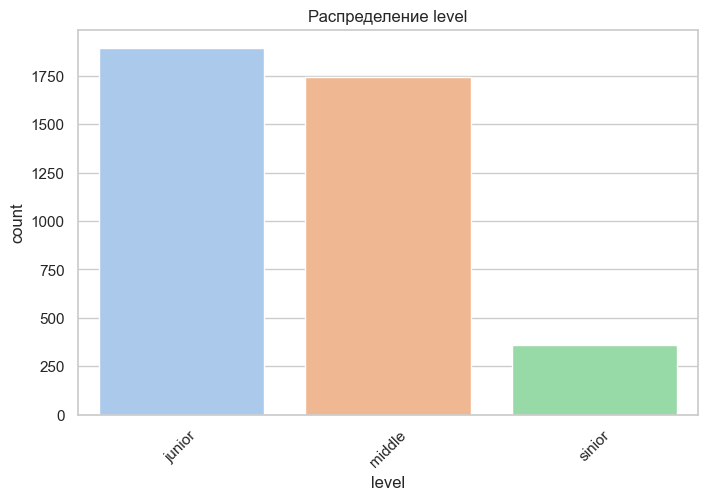

In [17]:
eda_describe_feature(X_train_sr, 'level')

##### `workload`


	Описательная статистика столбца - workload
count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object


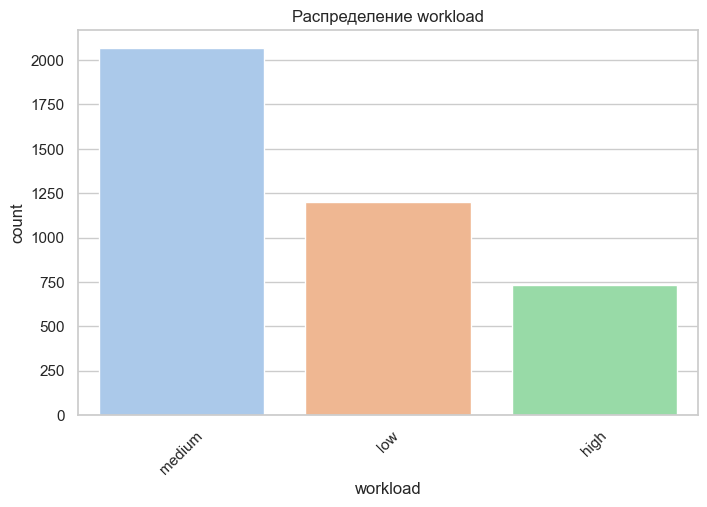

In [18]:
eda_describe_feature(X_train_sr, 'workload')

##### `employment_years`


	Описательная статистика столбца - employment_years
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


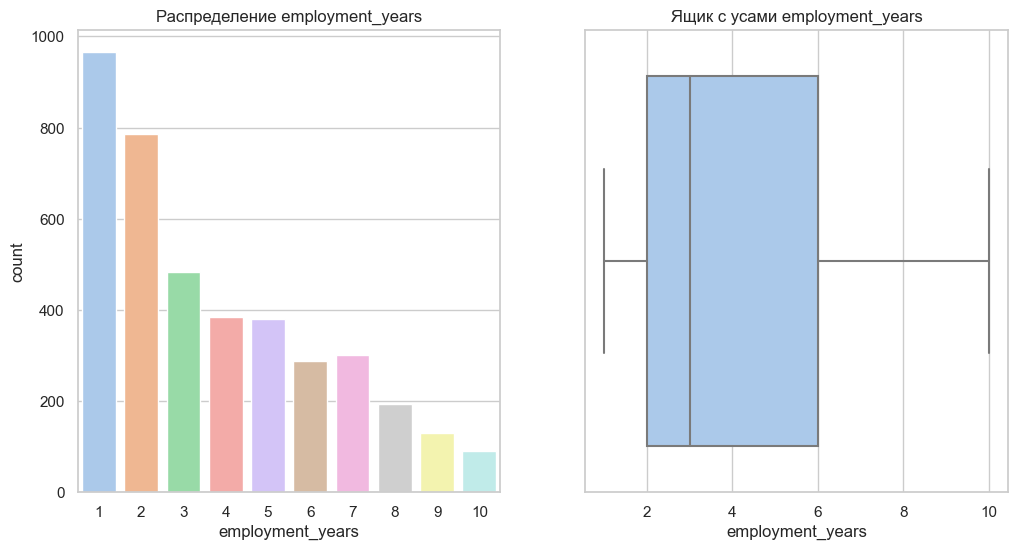

In [19]:
eda_describe_feature(X_train_sr, 'employment_years', is_discrete=True)


	Описательная статистика столбца - employment_years_segment
count            4000
unique              2
top       less than 3
freq             2234
Name: employment_years_segment, dtype: object


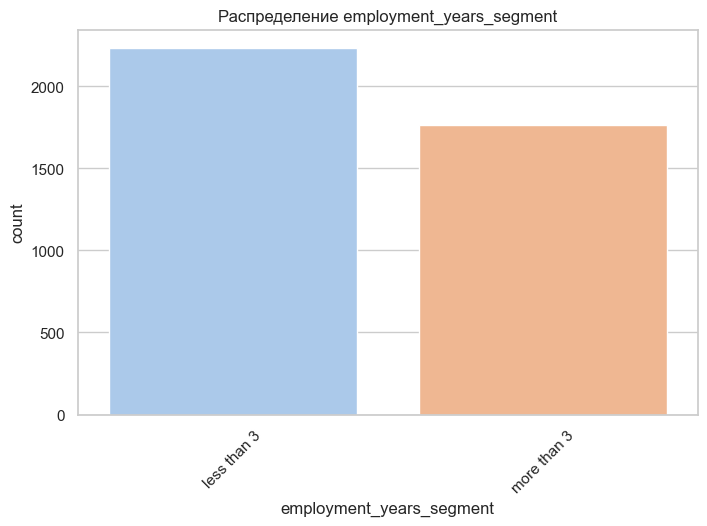

In [20]:
X_train_sr['employment_years_segment'] = pd.cut(X_train_sr['employment_years'], bins=[0, 3, 10],
                                                labels=["less than 3", "more than 3"]).astype(object)
eda_describe_feature(X_train_sr, 'employment_years_segment')

##### `last_year_promo`


	Описательная статистика столбца - last_year_promo
count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object


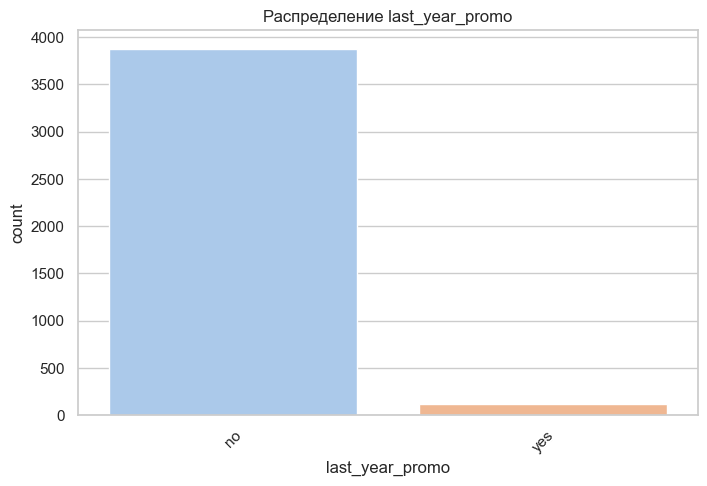

In [21]:
eda_describe_feature(X_train_sr, 'last_year_promo')

In [22]:
X_train_sr.groupby('last_year_promo')['job_satisfaction_rate'].mean()

last_year_promo
no     0.529696
yes    0.673000
Name: job_satisfaction_rate, dtype: float64

##### `last_year_violations`


	Описательная статистика столбца - last_year_violations
count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object


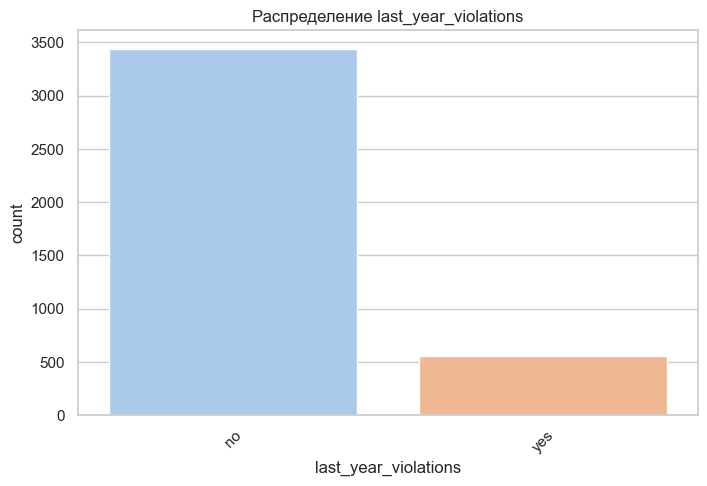

In [23]:
eda_describe_feature(X_train_sr, 'last_year_violations')

In [24]:
X_train_sr.groupby('last_year_violations')['job_satisfaction_rate'].mean()

last_year_violations
no     0.568759
yes    0.320000
Name: job_satisfaction_rate, dtype: float64

##### `supervisor_evaluation`


	Описательная статистика столбца - supervisor_evaluation
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


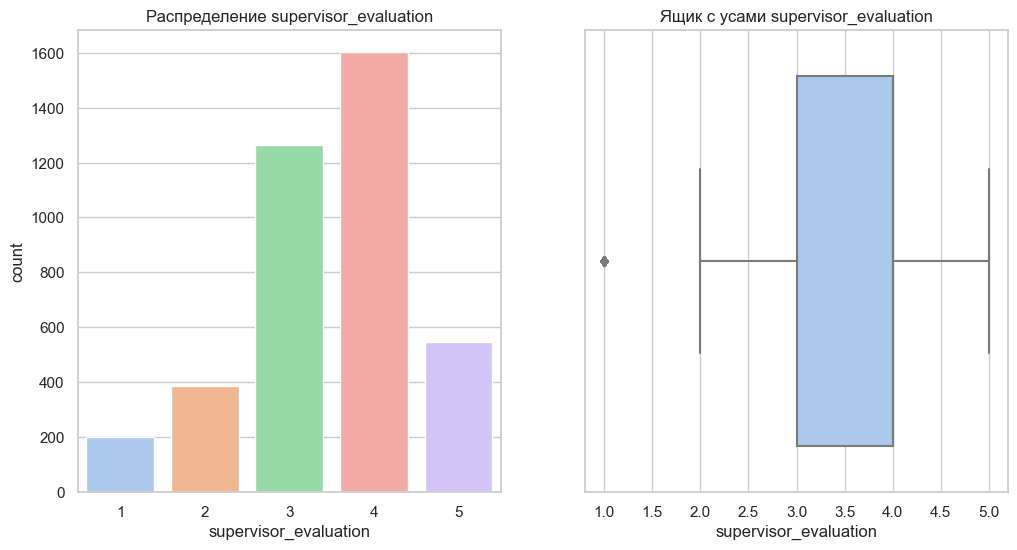

In [25]:
eda_describe_feature(X_train_sr, 'supervisor_evaluation', is_discrete=True)


	Описательная статистика столбца - supervisor_evaluation_segment
count            4000
unique              2
top       more than 4
freq             2149
Name: supervisor_evaluation_segment, dtype: object


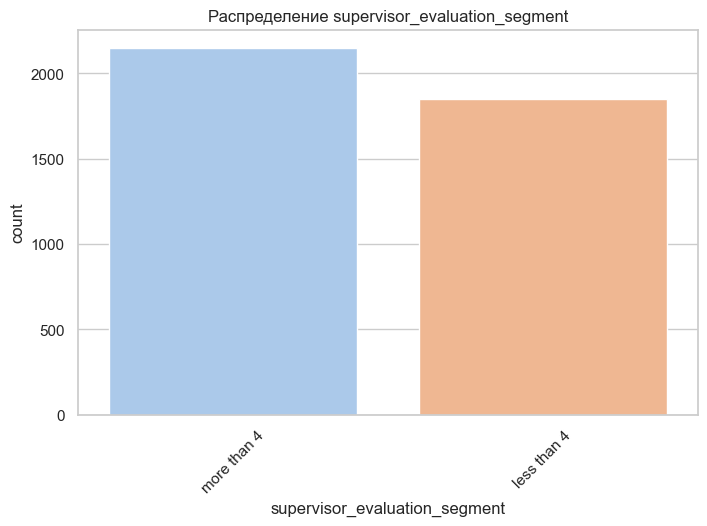

In [26]:
X_train_sr['supervisor_evaluation_segment'] = pd.cut(X_train_sr['supervisor_evaluation'],
                                                    bins=[0, 3.9, 5],
                                                    labels=["less than 4", "more than 4"]).astype(object)
eda_describe_feature(X_train_sr, 'supervisor_evaluation_segment')

##### `salary`


	Описательная статистика столбца - salary
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


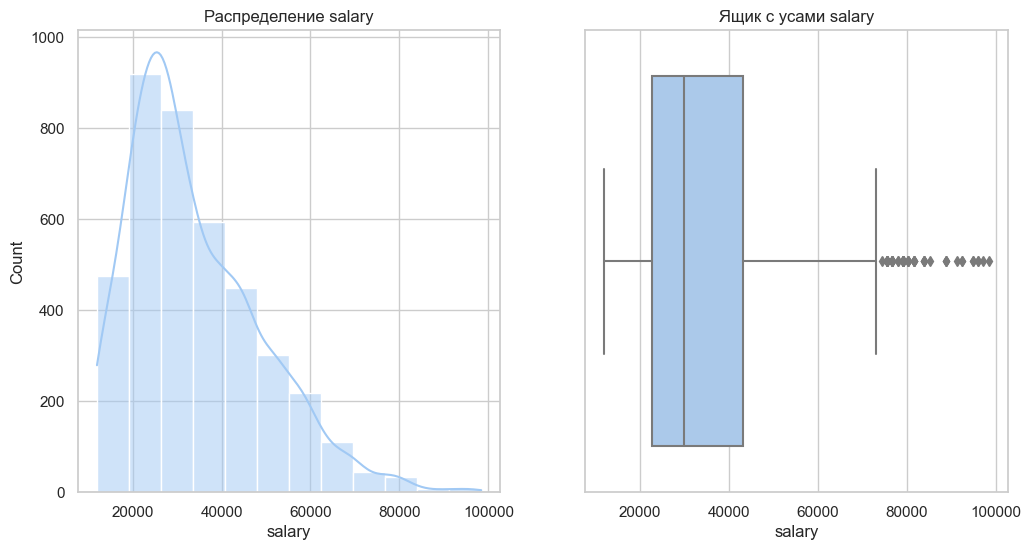

In [27]:
eda_describe_feature(X_train_sr, 'salary')

In [28]:
X_train_sr['salary_log1p'] = np.log1p(X_train_sr['salary'])


	Описательная статистика столбца - salary_log1p
count    4000.000000
mean       10.338474
std         0.435711
min         9.392745
25%        10.034560
50%        10.308986
75%        10.673619
max        11.496806
Name: salary_log1p, dtype: float64


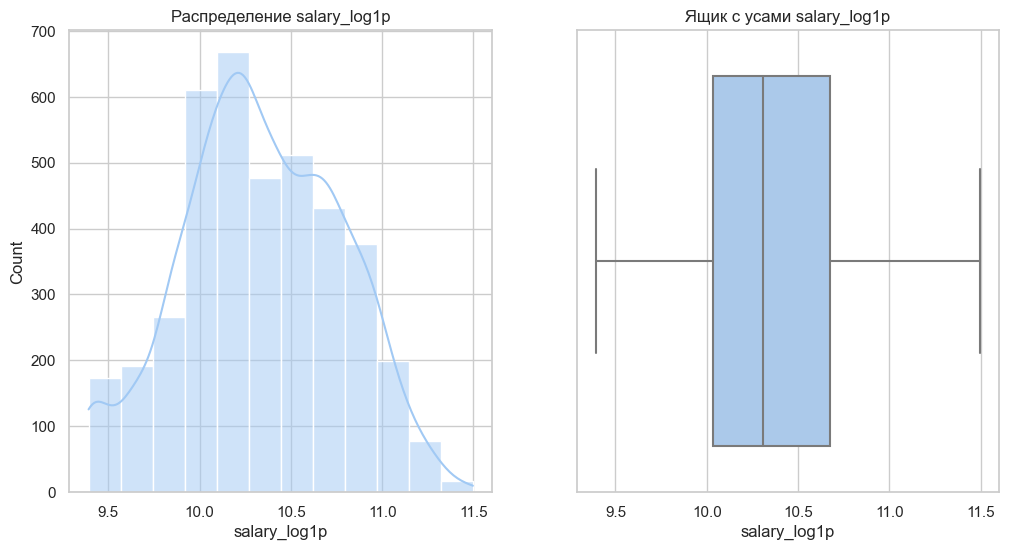

In [29]:
eda_describe_feature(X_train_sr, 'salary_log1p')

##### `job_satisfaction_rate`


	Описательная статистика столбца - job_satisfaction_rate
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


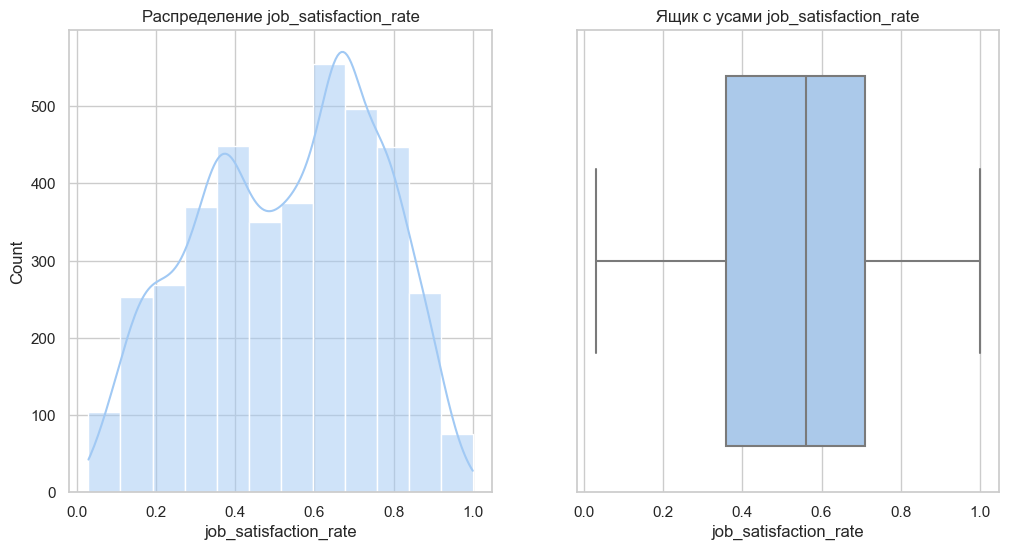

In [30]:
eda_describe_feature(X_train_sr, 'job_satisfaction_rate')

#### `X_test_sr`

##### `dept`


	Описательная статистика столбца - dept
count      1998
unique        6
top       sales
freq        763
Name: dept, dtype: object


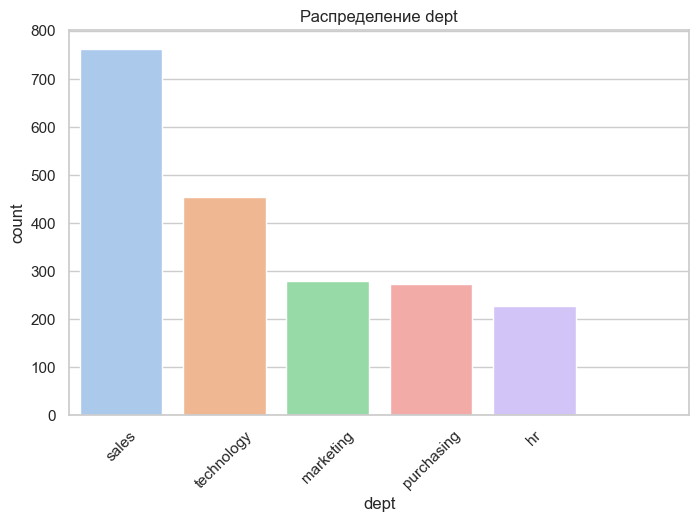

In [31]:
eda_describe_feature(X_test_sr, 'dept')

##### `level`


	Описательная статистика столбца - level
count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object


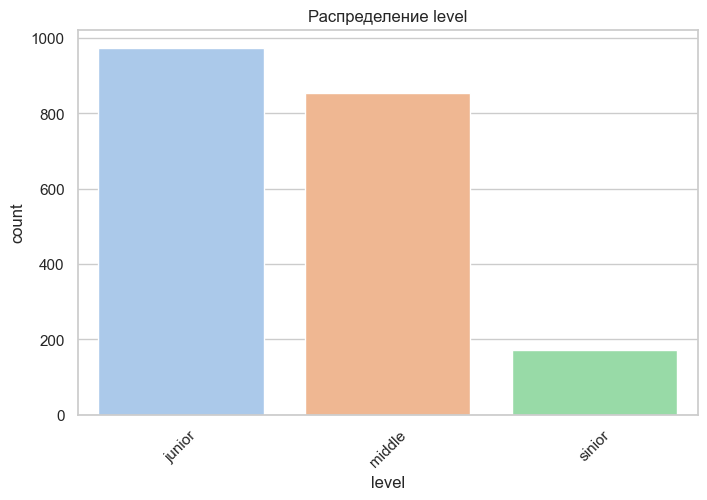

In [32]:
eda_describe_feature(X_test_sr, 'level')

##### `workload`


	Описательная статистика столбца - workload
count       2000
unique         4
top       medium
freq        1043
Name: workload, dtype: object


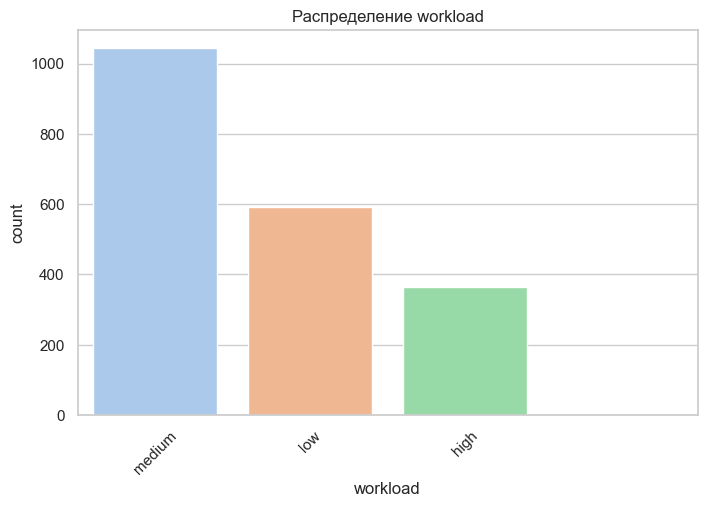

In [33]:
eda_describe_feature(X_test_sr, 'workload')

##### `employment_years`


	Описательная статистика столбца - employment_years
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


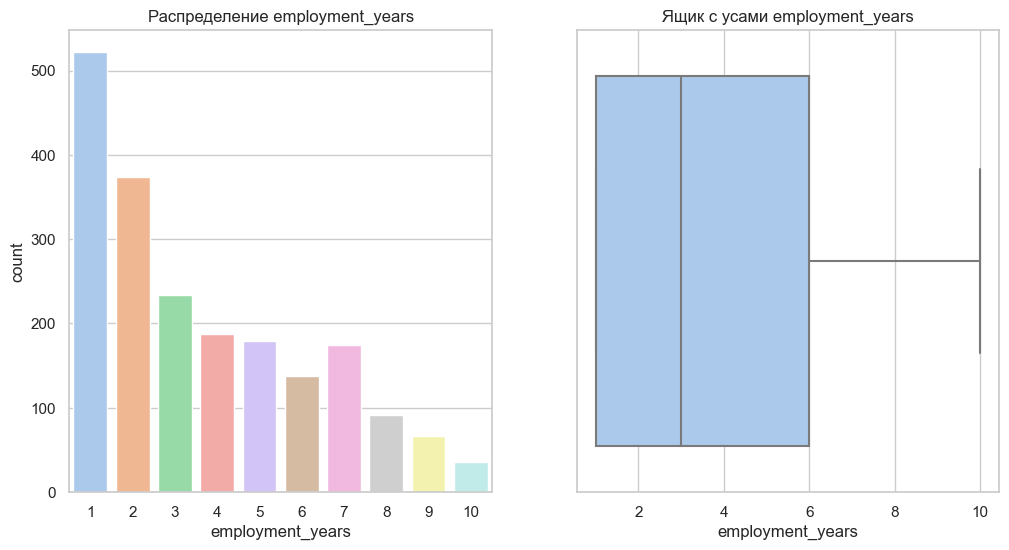

In [34]:
eda_describe_feature(X_test_sr, 'employment_years', is_discrete=True)


	Описательная статистика столбца - employment_years_segment
count            2000
unique              2
top       less than 3
freq             1130
Name: employment_years_segment, dtype: object


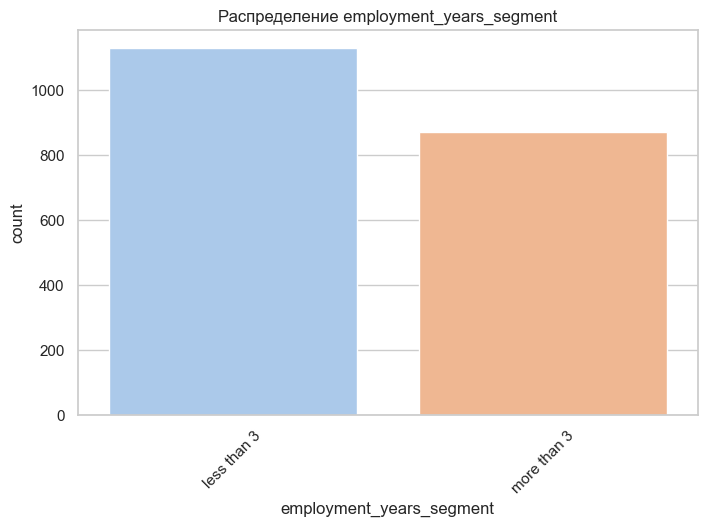

In [35]:
X_test_sr['employment_years_segment'] = pd.cut(X_test_sr['employment_years'], bins=[0, 3, 10],
                                               labels=["less than 3", "more than 3"]).astype(object)
eda_describe_feature(X_test_sr, 'employment_years_segment')

##### `last_year_promo`


	Описательная статистика столбца - last_year_promo
count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object


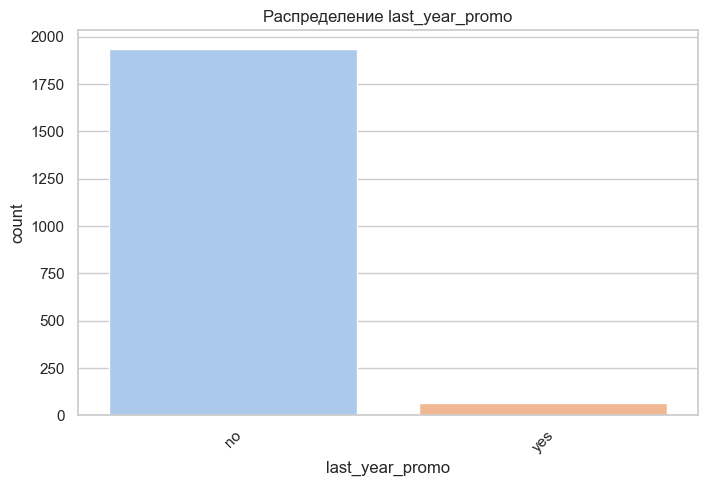

In [36]:
eda_describe_feature(X_test_sr, 'last_year_promo')

##### `last_year_violations`


	Описательная статистика столбца - last_year_violations
count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object


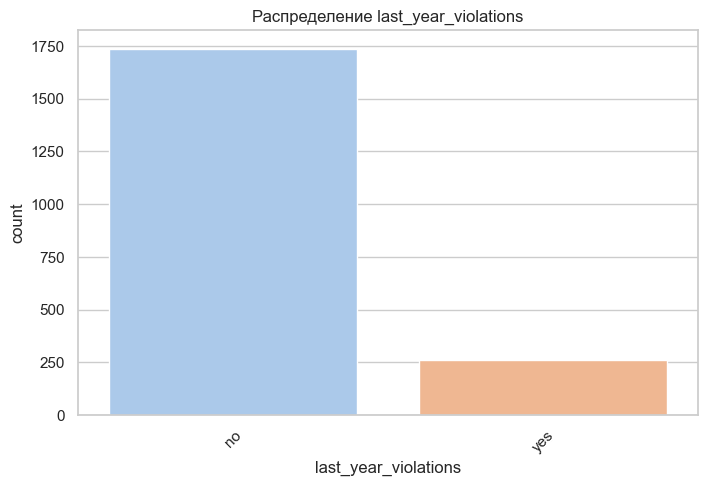

In [37]:
eda_describe_feature(X_test_sr, 'last_year_violations')

##### `supervisor_evaluation`


	Описательная статистика столбца - supervisor_evaluation
count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


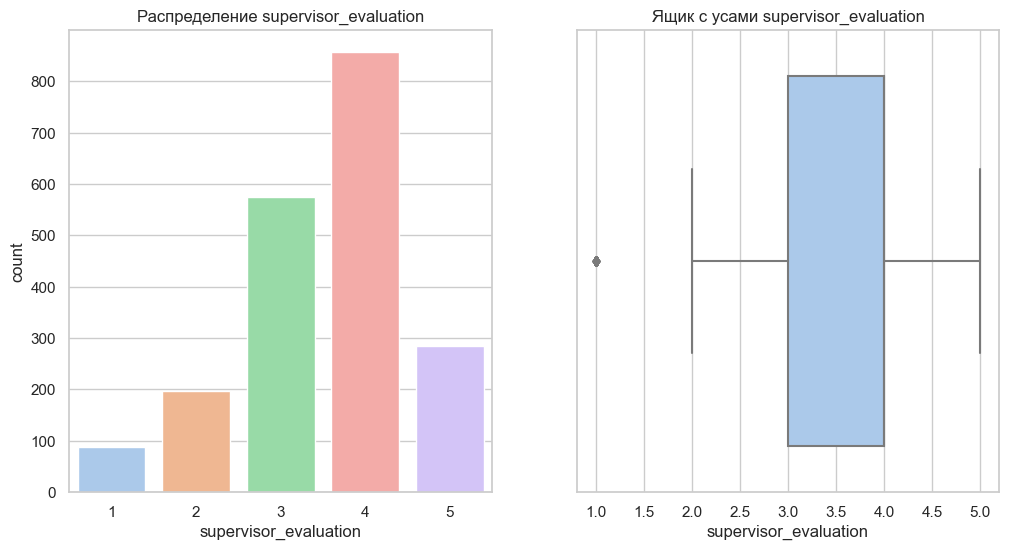

In [38]:
eda_describe_feature(X_test_sr, 'supervisor_evaluation', is_discrete=True)


	Описательная статистика столбца - supervisor_evaluation_segment
count            2000
unique              2
top       more than 4
freq             1141
Name: supervisor_evaluation_segment, dtype: object


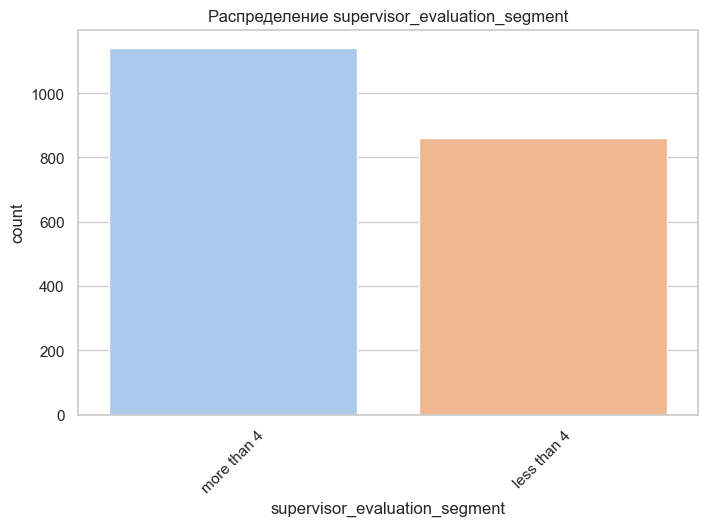

In [39]:
X_test_sr['supervisor_evaluation_segment'] = pd.cut(X_test_sr['supervisor_evaluation'],
                                                    bins=[0, 3.9, 5],
                                                    labels=["less than 4", "more than 4"]).astype(object)
eda_describe_feature(X_test_sr, 'supervisor_evaluation_segment')

##### `salary`


	Описательная статистика столбца - salary
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


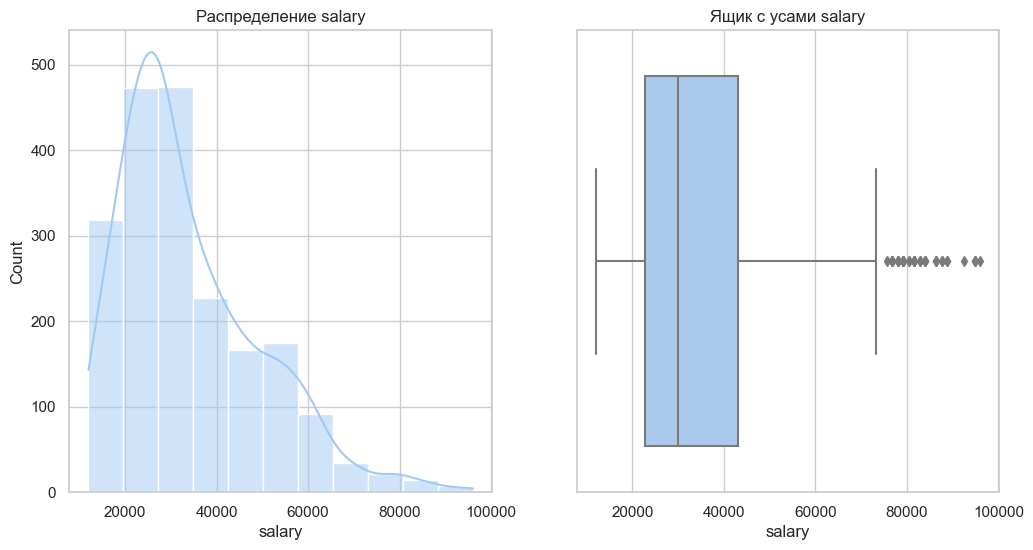

In [40]:
eda_describe_feature(X_test_sr, 'salary')


	Описательная статистика столбца - salary_log1p
count    2000.000000
mean       10.339633
std         0.439699
min         9.392745
25%        10.034560
50%        10.308986
75%        10.673619
max        11.472114
Name: salary_log1p, dtype: float64


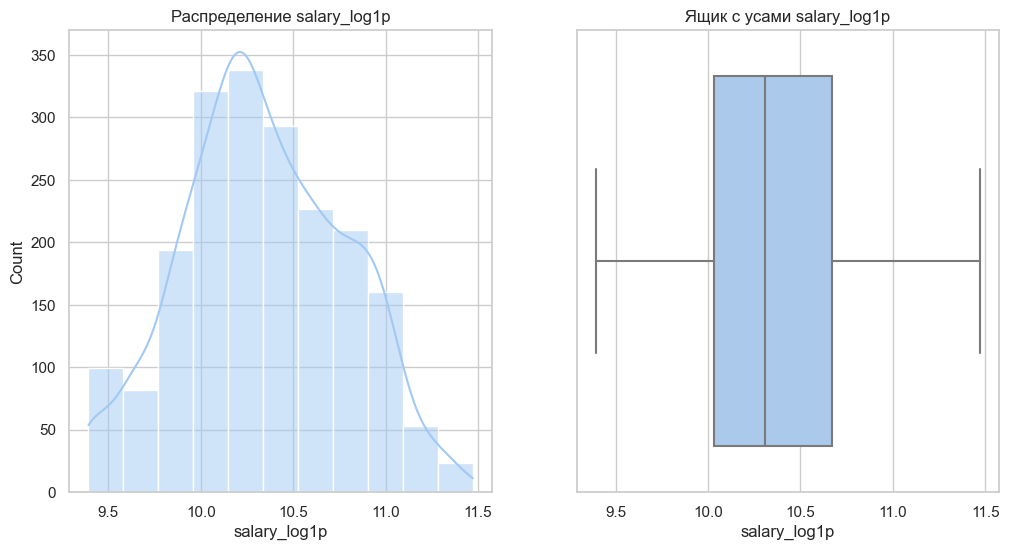

In [41]:
X_test_sr['salary_log1p'] = np.log1p(X_test_sr['salary'])
eda_describe_feature(X_test_sr, 'salary_log1p')

#### `y_test_sr`


	Описательная статистика столбца - job_satisfaction_rate
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


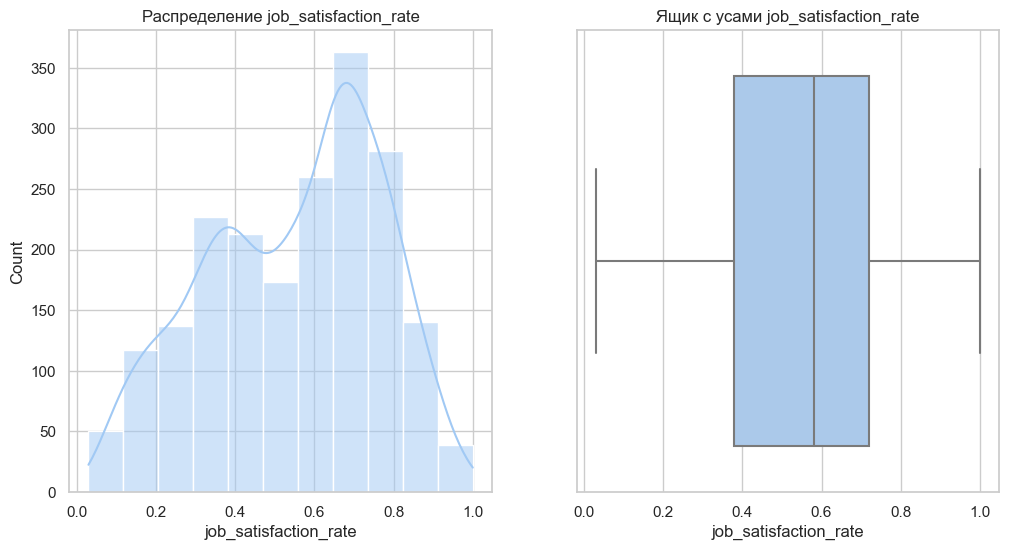

In [42]:
eda_describe_feature(y_test_sr, 'job_satisfaction_rate')

**Выводы**

Обработаны следующие признаки:
- `salary` -> `salary_log1p`. Для устранения положительной асимметрии с выбросами добавлен логарифм признака
- `employment_years` -> `employment_years_segment`. Для устранения положительной асимметрии добавлен новый признак через разбиение на категории старого.
- `supervisor_evaluation` -> `supervisor_evaluation_segment`. Для устранения отрицательной асимметрии добавлен новый признак через разбиение на категории старого.
- Пустые значения будут обработаны в пайплайне

### Корреляционный анализ

In [43]:
cat_col_names = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
num_col_names = ['employment_years', 'supervisor_evaluation', 'salary']

In [44]:
corr_matrix = X_train_sr.drop(columns='id').phik_matrix(interval_cols=['salary', 'salary_log1p', 'job_satisfaction_rate'])

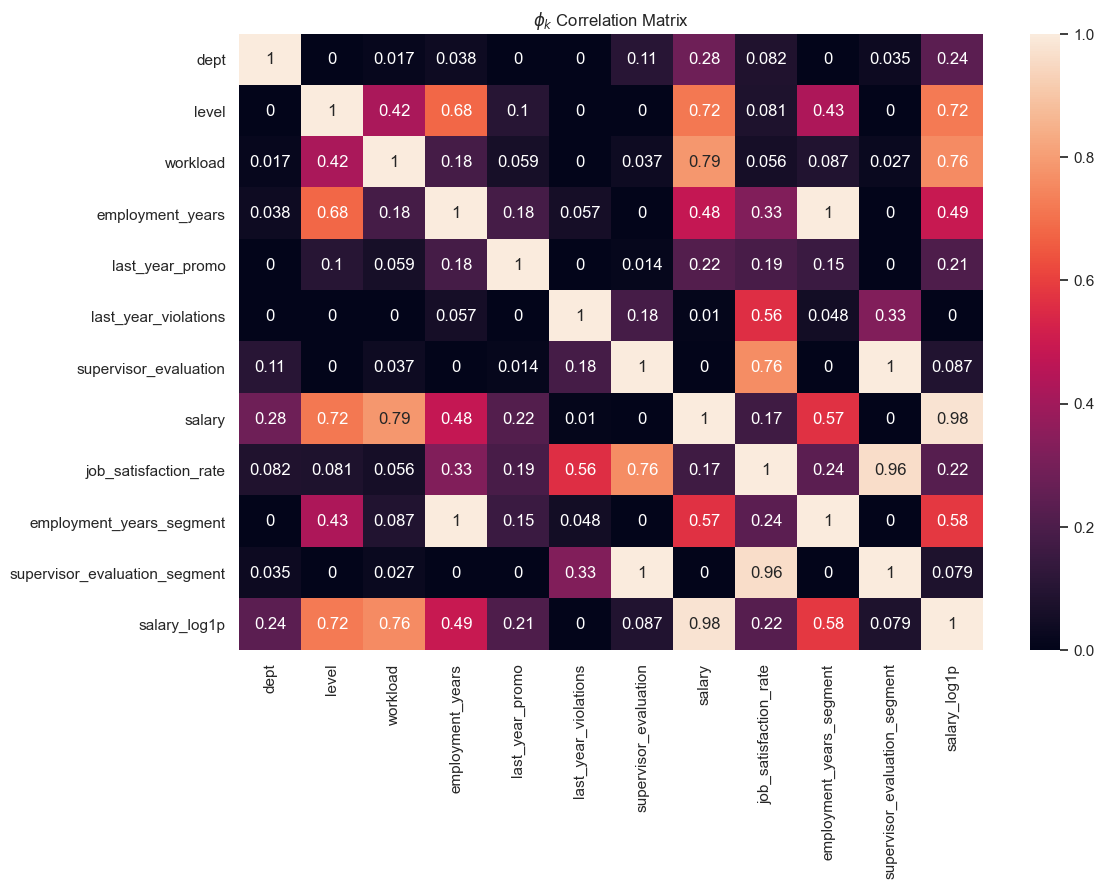

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('$\phi_k$ Correlation Matrix')
plt.show()

In [46]:
def plot_scatter(df, num_col, target, cat_hue):
    for col in [num_col, target, cat_hue]:
        if col not in df.columns:
            raise ValueError(f"Ошибка. Колонка '{col}' отсутствует в DataFrame")
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x=num_col, y=target, hue=cat_hue, style=cat_hue, size=target, sizes=(20, 200))
    plt.title(f'Диаграмма рассеяния для признака {target} и {num_col}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


	Для категориального признака - dept


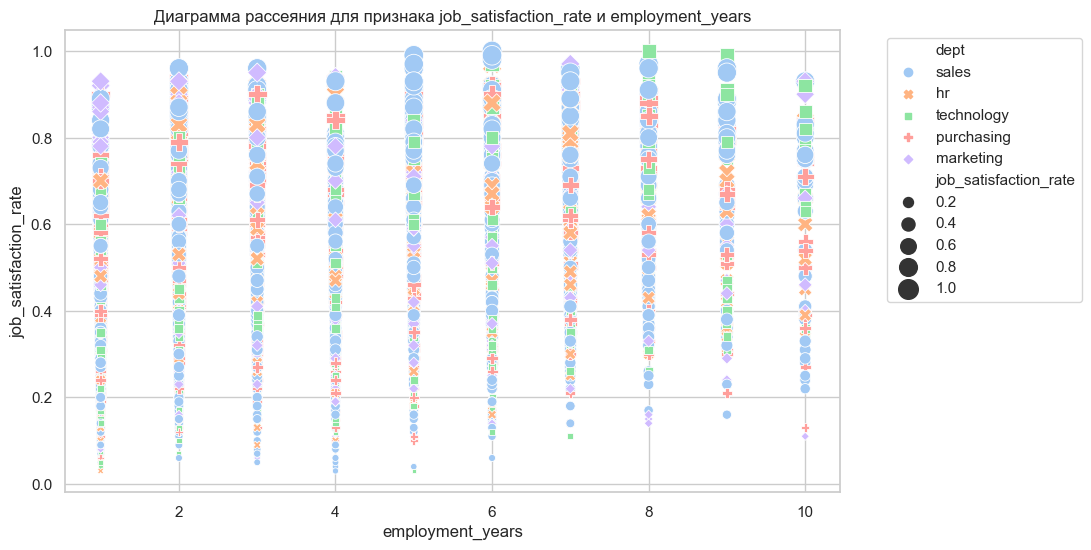

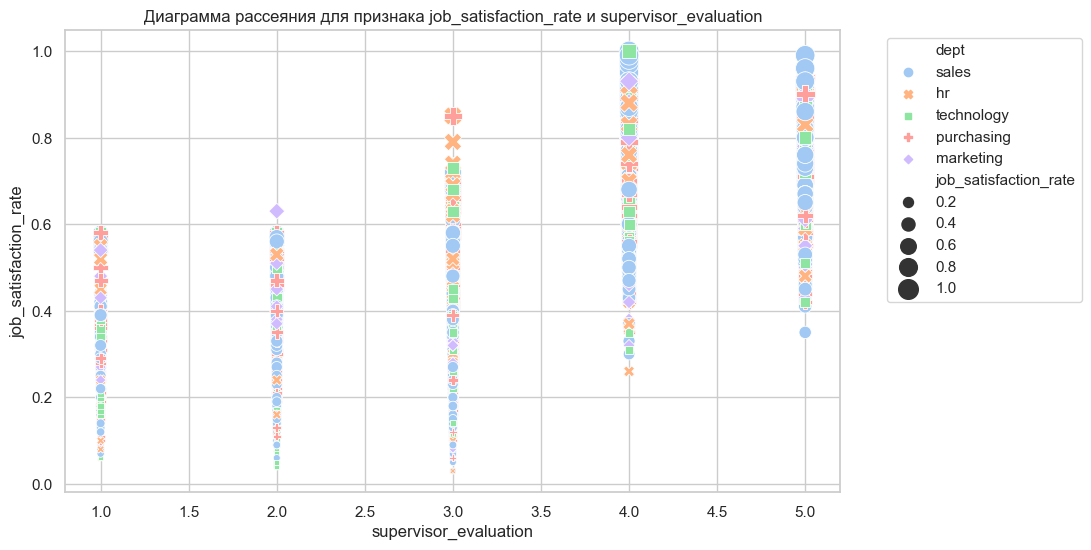

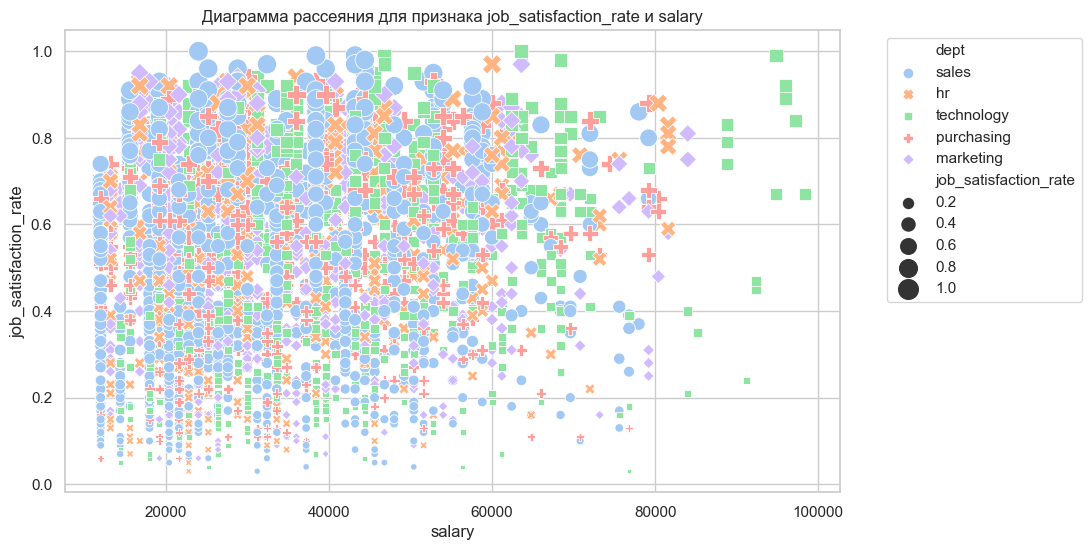


	Для категориального признака - level


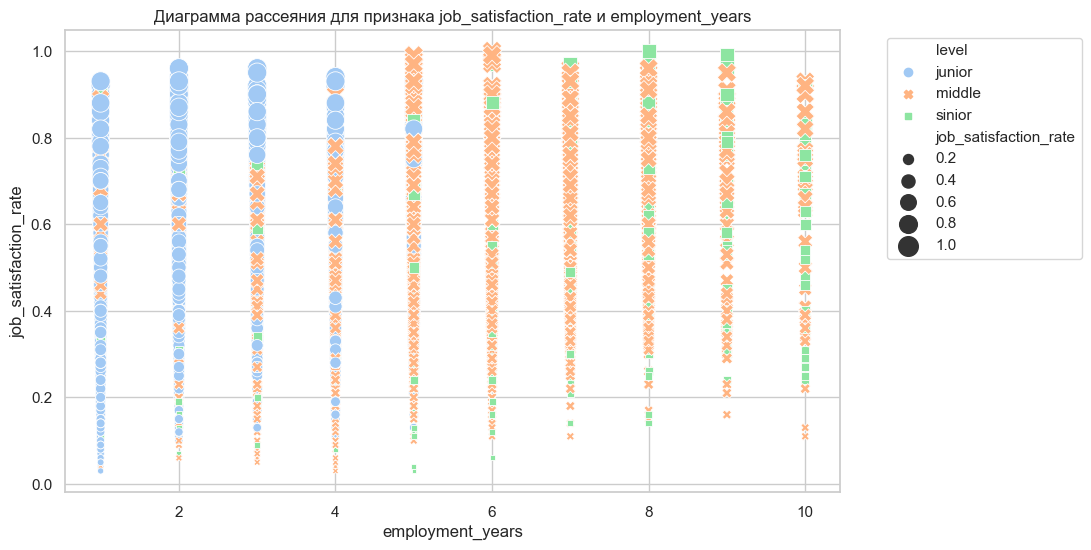

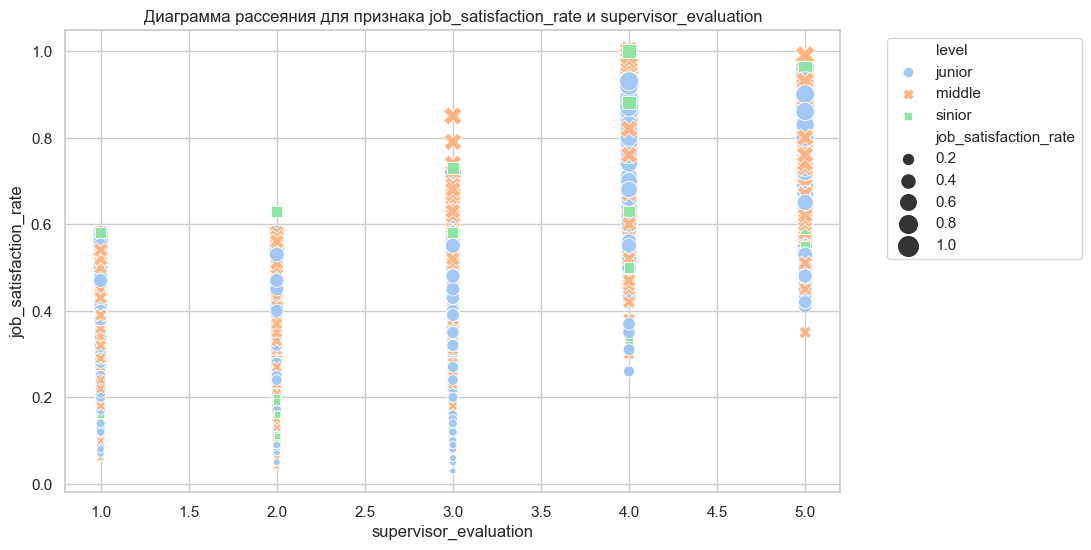

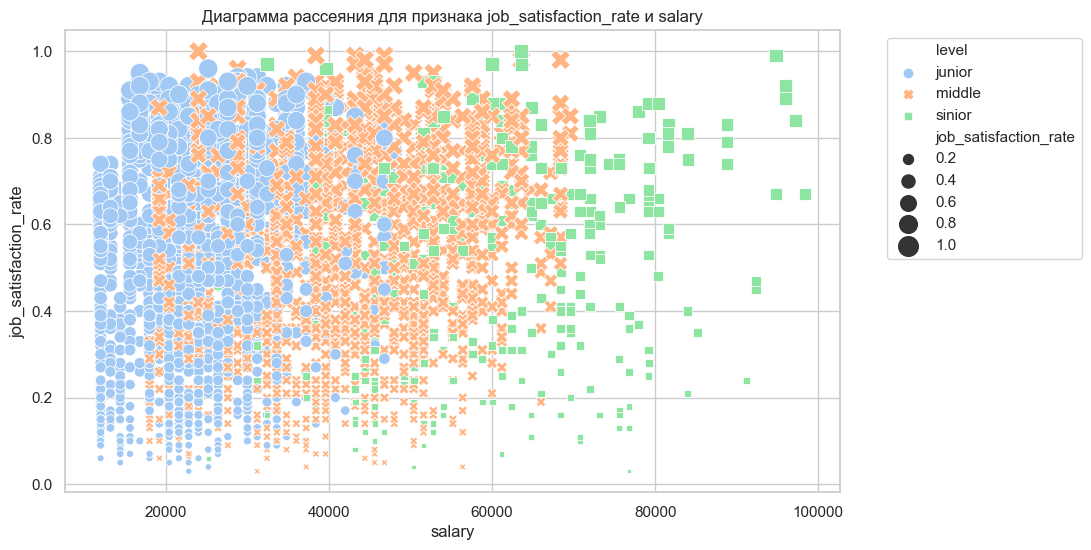


	Для категориального признака - workload


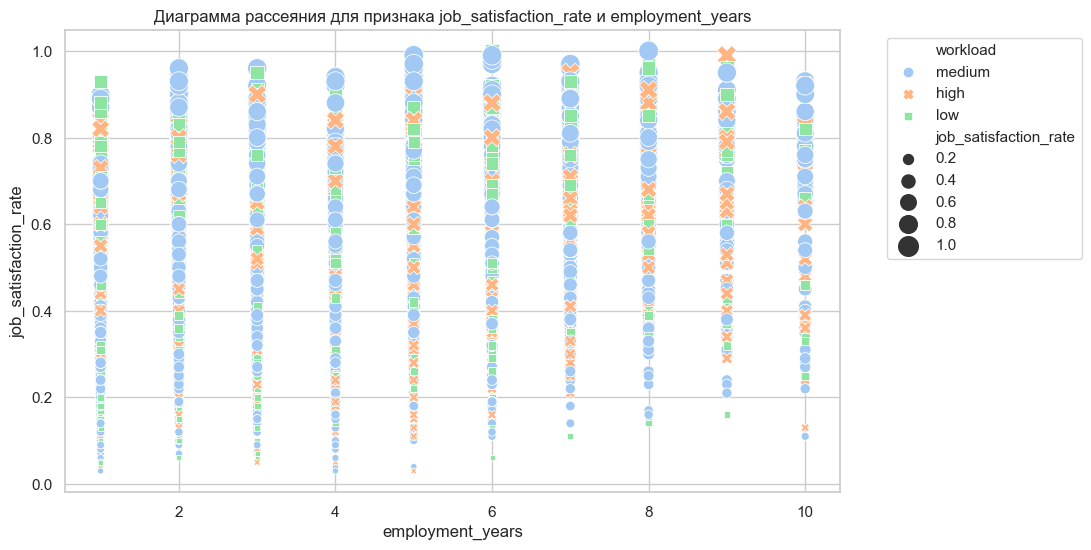

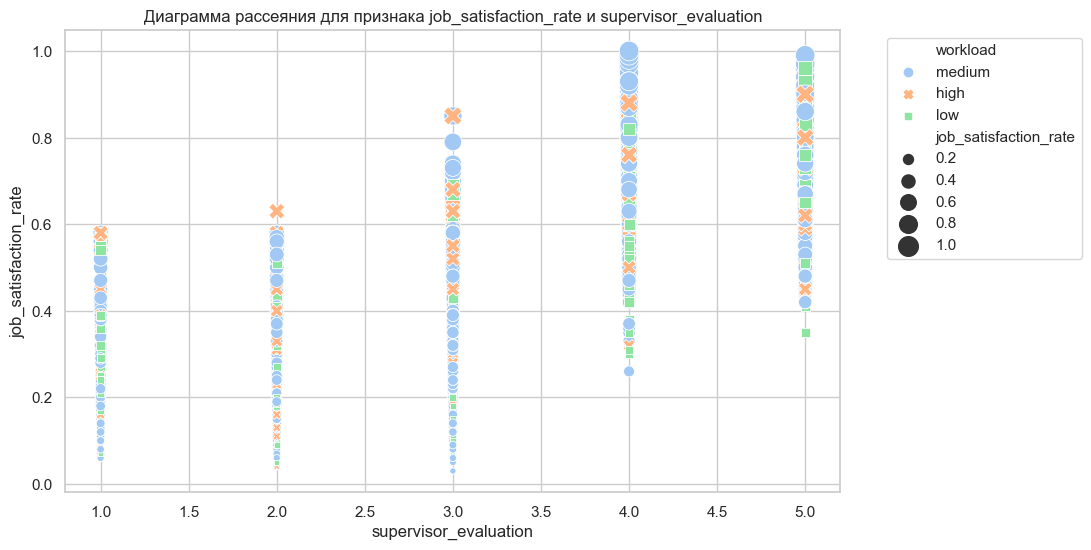

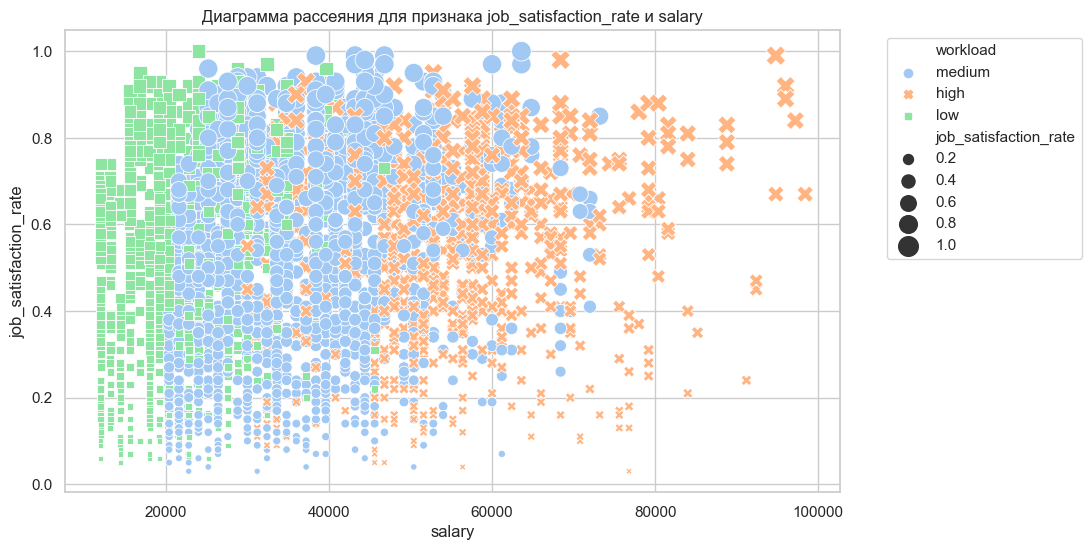


	Для категориального признака - last_year_promo


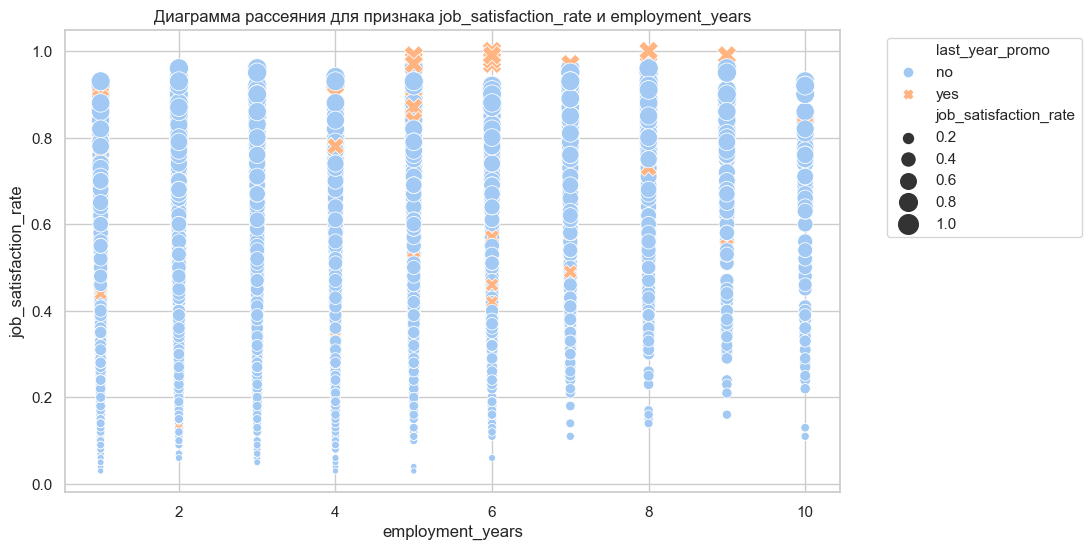

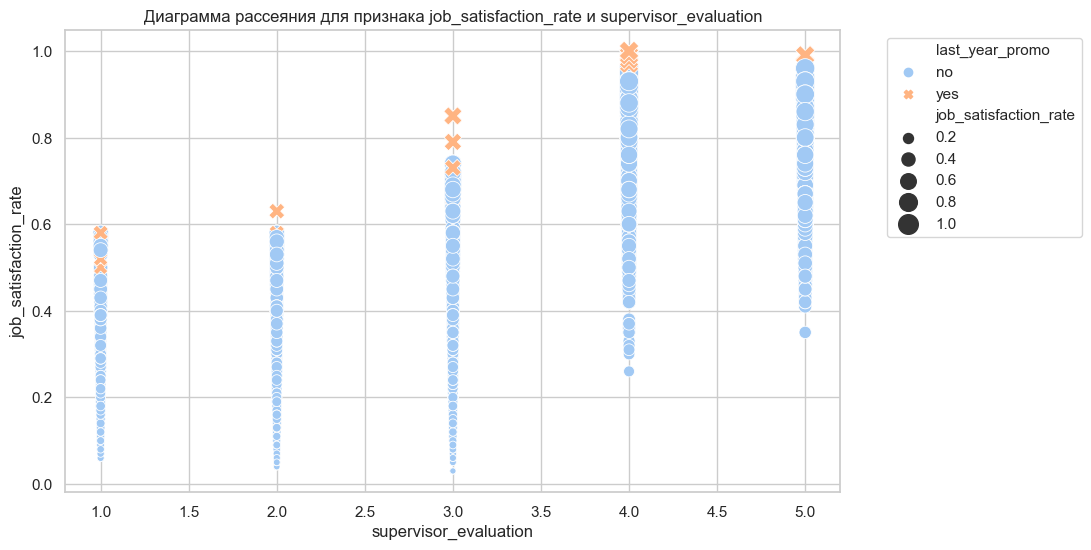

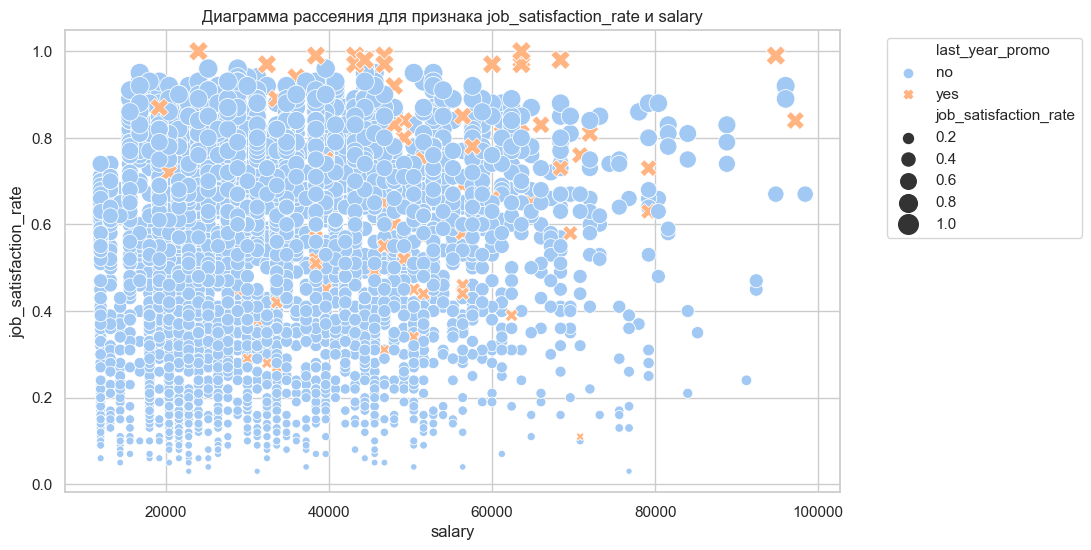


	Для категориального признака - last_year_violations


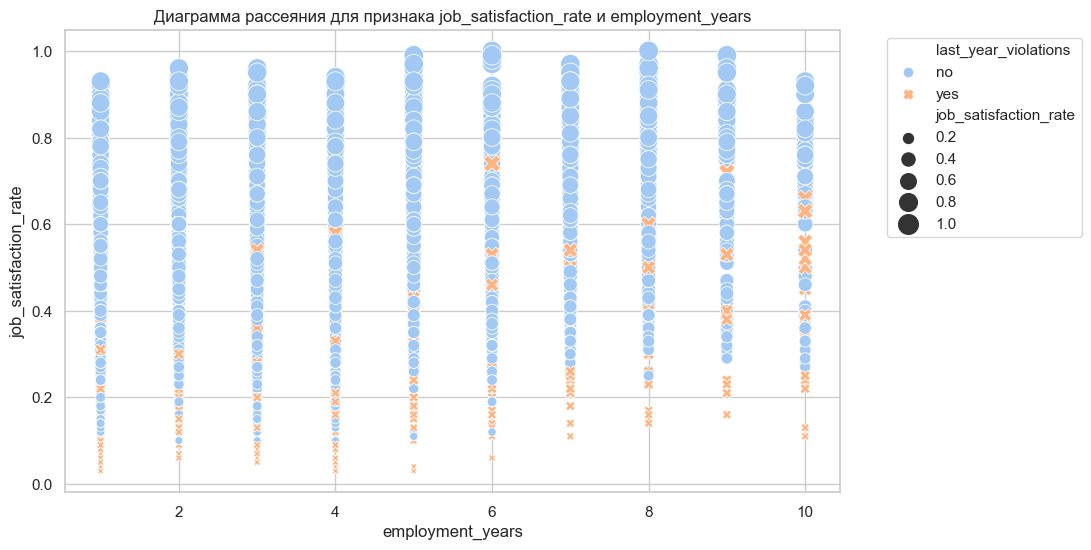

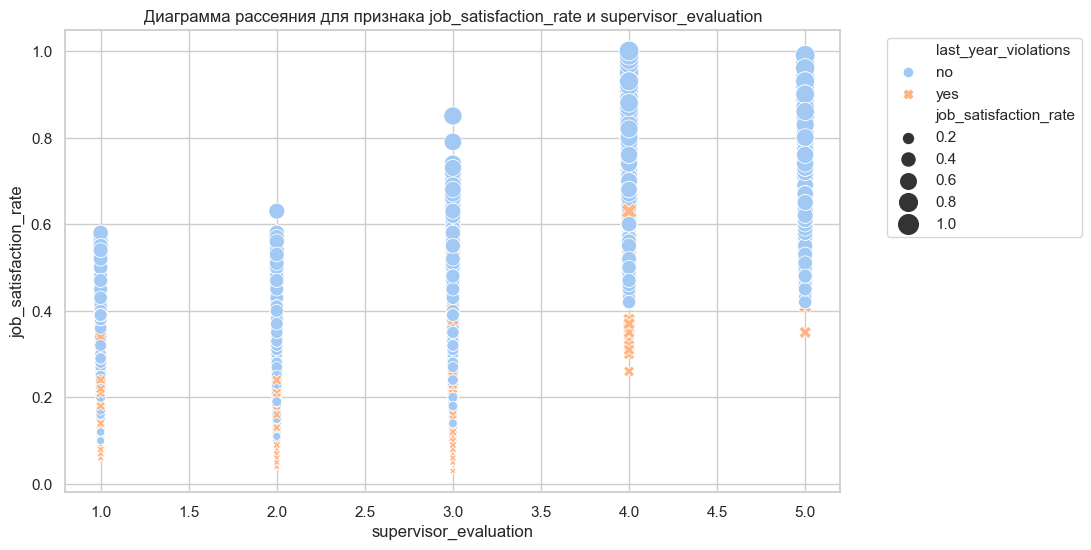

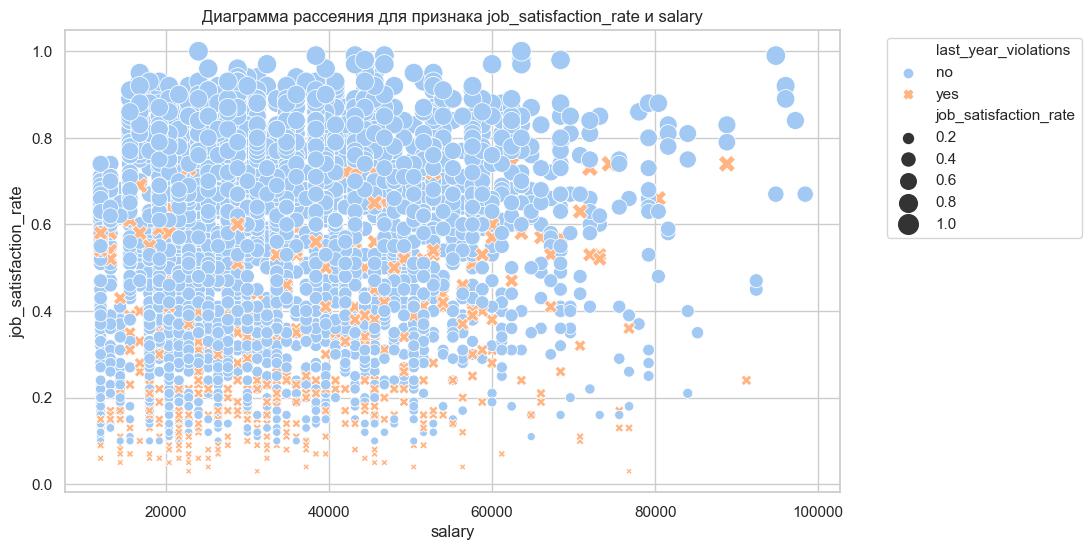

In [47]:
for cat_col in cat_col_names:
    print(f'\n\tДля категориального признака - {cat_col}')
    for num_col in num_col_names:
        plot_scatter(X_train_sr, num_col, 'job_satisfaction_rate', cat_col)

**Выводы**
- Уровень `job_satisfaction_rate` остается разбросанным вне зависимости от количества лет в компании. Даже у сотрудников с 8–10 годами стажа встречаются низкие значения удовлетворённости, как и у новых сотрудников.
- Чем выше оценка качества работы, тем выше у сотрудника уровень его удовлетворенности в среднем.
- Низкие оценки руководителей (1–2) почти не приводят к высокой удовлетворенности. Почти отсутствуют крупные точки (высокая удовлетворенность) при низкой `supervisor_evaluation`. Это может говорить либо о слабом лидерстве, либо о демотивации в подразделениях, где оценивают низко.
- Во всех департаментах при одинаковой supervisor_evaluation наблюдаются схожие уровни `job_satisfaction_rate` — сильной зависимости от отдела нет.
- С увеличением зарплаты удовлетворенность работой растет, но эффект более выражен в отделах продаж и технологий.
- Повышение позитивно влияет на уровень удовлетворенности. У тех кого повысили уровень `job_satisfaction_rate` выше, чем у остальных.
- У сотрудников с высокой оценкой руководителя (4–5), но низким уровнем удовлетворённости (0–0.4) наблюдаются чаще нарушения (крестики). Это может говорить о скрытом напряжении: формально всё хорошо, но сотрудники не довольны, что проявляется в поведении.
- Большинство сотрудников, которые нарушали трудовой договор меньше удовлетворены работой, чем те кто не нарушал, даже вне зависимости от получаемой зарплаты.

### Подготовка данных

In [48]:
X_train = X_train_sr.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = X_train_sr['job_satisfaction_rate']

test = X_test_sr.merge(y_test_sr, on='id', how='left')
X_test = test.drop('id', axis=1)
y_test = test['job_satisfaction_rate']

In [49]:
X_train_sr.head(2)

id   dept   level workload  employment_years last_year_promo  \
0  155278  sales  junior   medium                 2              no   
1  653870     hr  junior     high                 2              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  \
0                   no                      1   24000                   0.58   
1                   no                      5   38400                   0.76   

  employment_years_segment supervisor_evaluation_segment  salary_log1p  
0              less than 3                   less than 4     10.085851  
1              less than 3                   more than 4     10.555839

In [50]:
ord_columns = ['level', 'workload']
ohe_columns = list(set(X_train.select_dtypes(exclude='number').columns) - set(ord_columns))
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [51]:
def replace_blank_with_nan(X):
    return pd.DataFrame(X).replace(' ', np.nan)

In [52]:
ohe_pipeline = Pipeline([
    ('replace_blanks', FunctionTransformer(replace_blank_with_nan,
                                           feature_names_out='one-to-one')),
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [53]:
ord_pipeline = Pipeline([
    ('replace_blanks', FunctionTransformer(replace_blank_with_nan,
                                           feature_names_out='one-to-one')),
    ('simpleImputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high'],
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)
    ),
    ('simpleImputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [54]:
num_pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    #('select', SelectKBest(score_func=f_regression, k=5)),
    ('scaler', StandardScaler())
])

In [55]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipeline, ohe_columns),
        ('ord', ord_pipeline, ord_columns),
        ('num', num_pipeline, num_columns)
    ],
    remainder='passthrough',
)

In [56]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    #('select', SelectKBest(score_func=f_regression, k=5)),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE)),
])

In [57]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__min_samples_split':[10, 20],
        'models__min_samples_leaf': [10, 20, 30],
        #'preprocessor__num__select__k': [5, 10, 15],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(
        )],
        #'preprocessor__num__select__k': [5, 10, 15],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    # словарь для модели Ridge()
    {
        'models': [Ridge(
        )],
        'models__alpha': range(1, 10),
        #'preprocessor__num__select__k': [5, 10, 15],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    # словарь для модели Ridge()
    {
        'models': [KNeighborsRegressor(
        )],
        'models__n_neighbors': range(1, 10),
        #'preprocessor__num__select__k': [5, 10, 15],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
]

### Обучение моделей

In [58]:
# Функция для расчета метрики SMAPE
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    # Добавим защиту от деления на ноль
    mask = denominator != 0

    return np.mean(numerator[mask] / denominator[mask]) * 100

In [59]:
smape_score = make_scorer(smape, greater_is_better=False)

In [60]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('replace_blanks',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function replace_blank_with_nan at 0x0000022A4B5A2B80>)),
                                                                                         ('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder...
                                                        'passthrough']},
                         {'models': [Ridge()], 'models__alpha': range(1, 10),
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        MinMaxScaler(),
                                                        'passthrough']},
                         {'models': [KNeighborsRegressor()],
                          'models__n_neighbors': range(1, 10),
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        MinMaxScaler(),
                                                        'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [61]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)
print(f'Метрика лучшей модели на тренировочной выборке: {-grid_search.best_score_:.2f}') # Отрицательное, так как greater_is_better=False

Лучшая модель и её параметры:

 {'models': Ridge(), 'models__alpha': 1, 'preprocessor__num__scaler': StandardScaler()}
Метрика лучшей модели на тренировочной выборке: 15.57


In [62]:
y_pred = grid_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_pred):.2f}')

Метрика SMAPE на тестовой выборке: 15.25


### Промежуточные выводы

На текущем этапе были протестированы несколько моделей, включая `LinearRegression`, `DecisionTreeRegressor`, `Ridge` и `KNeighborsRegressor`. Лучшие результаты по метрике SMAPE показала модель `Ridge`, достигнув значения SMAPE = 15.25 на тестовой выборке, что удовлетворяет критерию качества.

Основная причина её преимущества — в L2-регуляризации (штрафа на большие коэффициенты), `Ridge` «заставляет» модель быть проще, тем самым уменьшая переобучение, особенно при наличии большого числа признаков. В отличие от неё, `LinearRegression` не справилась с задачей из-за своей линейной природы, а `DecisionTreeRegressor` показала себя хуже при расчете метрик.

## Задача №2

### Загрузка данных

In [63]:
X_train_quit = load_df('train_quit.csv')


	Первые строки датафрейма


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no



	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


	Описательная статистика о количественных признаках


count          mean            std       min  \
id                     4000.0  552099.28375  260158.031387  100222.0   
employment_years       4000.0       3.70150       2.541852       1.0   
supervisor_evaluation  4000.0       3.47475       1.004049       1.0   
salary                 4000.0   33805.80000   15152.415163   12000.0   

                             25%       50%        75%       max  
id                     327785.75  546673.0  781497.75  999915.0  
employment_years            2.00       3.0       6.00      10.0  
supervisor_evaluation       3.00       4.0       4.00       5.0  
salary                  22800.00   30000.0   43200.00   96000.0



	Описательная статистика о качественных признаках


count unique     top  freq
dept                  4000      5   sales  1438
level                 4000      3  junior  1949
workload              4000      3  medium  2118
last_year_promo       4000      2      no  3887
last_year_violations  4000      2      no  3455
quit                  4000      2      no  2872

In [64]:
y_test_quit = load_df('test_target_quit.csv')


	Первые строки датафрейма


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes



	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


	Описательная статистика о количественных признаках


count         mean            std       min       25%       50%  \
id  2000.0  552765.2135  253851.326129  100298.0  339052.0  550793.0   

          75%       max  
id  765763.75  999029.0



	Описательная статистика о качественных признаках


count unique top  freq
quit  2000      2  no  1436

**Выводы**

Данные загружены. Пропусков нет

### Предобработка данных

In [65]:
check_dupl_nans(X_train_quit)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце dept уникальных значений = 5
Список уникальных значений = ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

В столбце level уникальных значений = 3
Список уникальных значений = ['middle' 'junior' 'sinior'] 

В столбце workload уникальных значений = 3
Список уникальных значений = ['high' 'medium' 'low'] 

В столбце last_year_promo уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 

В столбце last_year_violations уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 

В столбце quit уникальных значений = 2
Список уникальных значений = ['no' 'yes'] 


	Количество пропущенных значений
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

	Типы данных
id        

In [66]:
check_dupl_nans(y_test_quit)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце quit уникальных значений = 2
Список уникальных значений = ['yes' 'no'] 


	Количество пропущенных значений
id      0
quit    0
dtype: int64

	Типы данных
id       int64
quit    object
dtype: object


**Выводы**
- Полных дубликатов нет

### Исследовательский анализ данных

#### `X_train_quit`

##### `dept`


	Описательная статистика столбца - dept
count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object


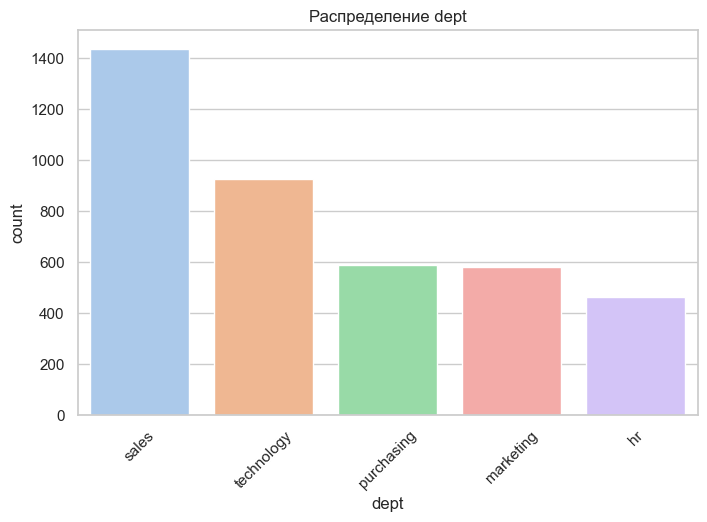

In [67]:
eda_describe_feature(X_train_quit, 'dept')

##### `level`


	Описательная статистика столбца - level
count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object


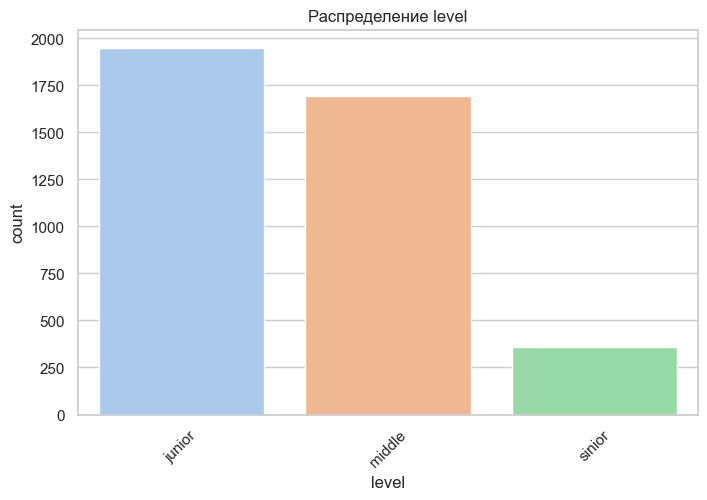

In [68]:
eda_describe_feature(X_train_quit, 'level')

##### `workload`


	Описательная статистика столбца - workload
count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object


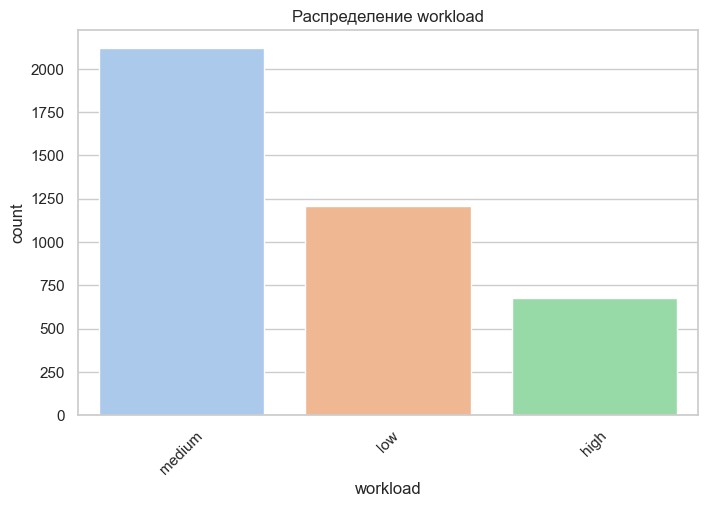

In [69]:
eda_describe_feature(X_train_quit, 'workload')

##### `employment_years`


	Описательная статистика столбца - employment_years
count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


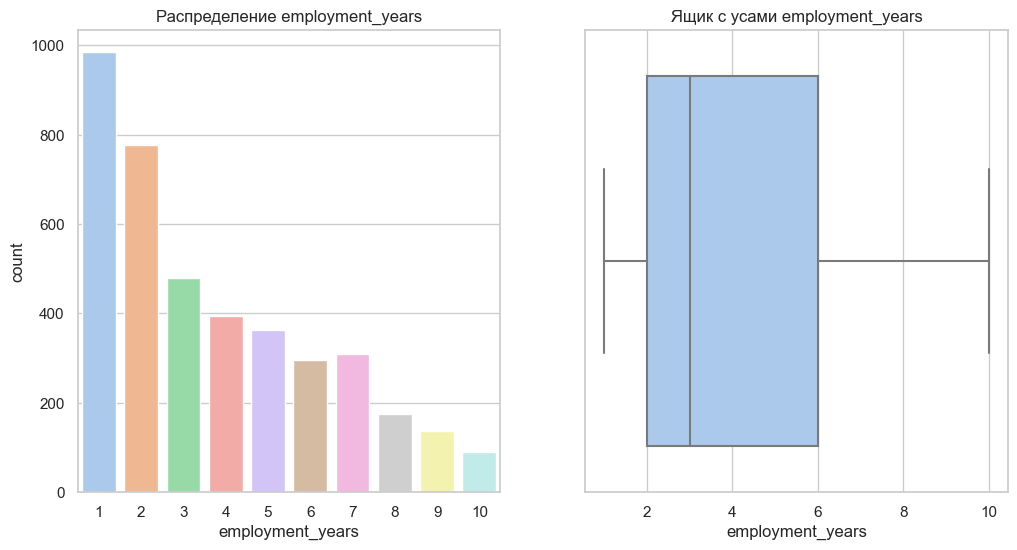

In [70]:
eda_describe_feature(X_train_quit, 'employment_years', is_discrete=True)


	Описательная статистика столбца - employment_years_segment
count            4000
unique              2
top       less than 3
freq             2241
Name: employment_years_segment, dtype: object


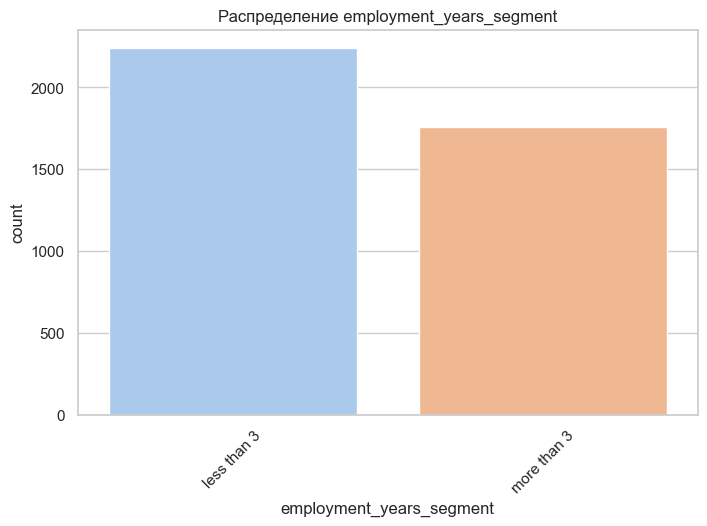

In [71]:
X_train_quit['employment_years_segment'] = pd.cut(X_train_quit['employment_years'], bins=[0, 3, 10],
                                                labels=["less than 3", "more than 3"]).astype(object)
eda_describe_feature(X_train_quit, 'employment_years_segment')

##### `last_year_promo`


	Описательная статистика столбца - last_year_promo
count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object


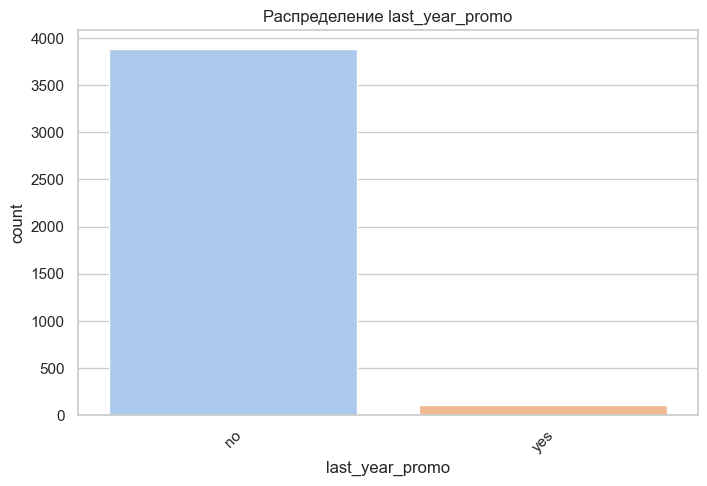

In [72]:
eda_describe_feature(X_train_quit, 'last_year_promo')

##### `last_year_violations`


	Описательная статистика столбца - last_year_violations
count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object


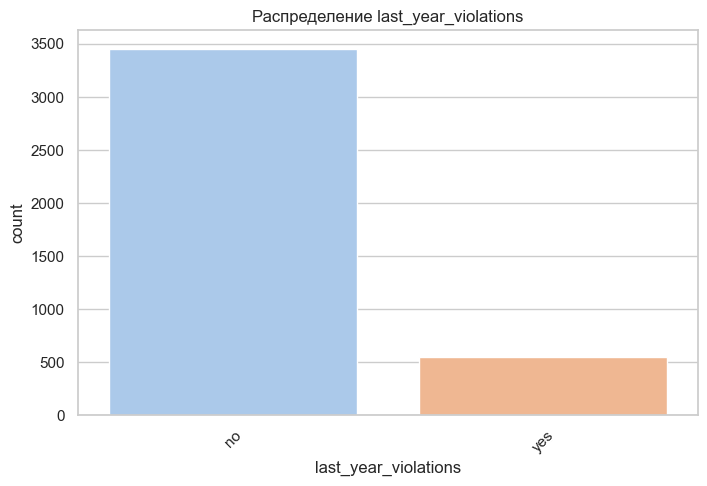

In [73]:
eda_describe_feature(X_train_quit, 'last_year_violations')

##### `supervisor_evaluation`


	Описательная статистика столбца - supervisor_evaluation
count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


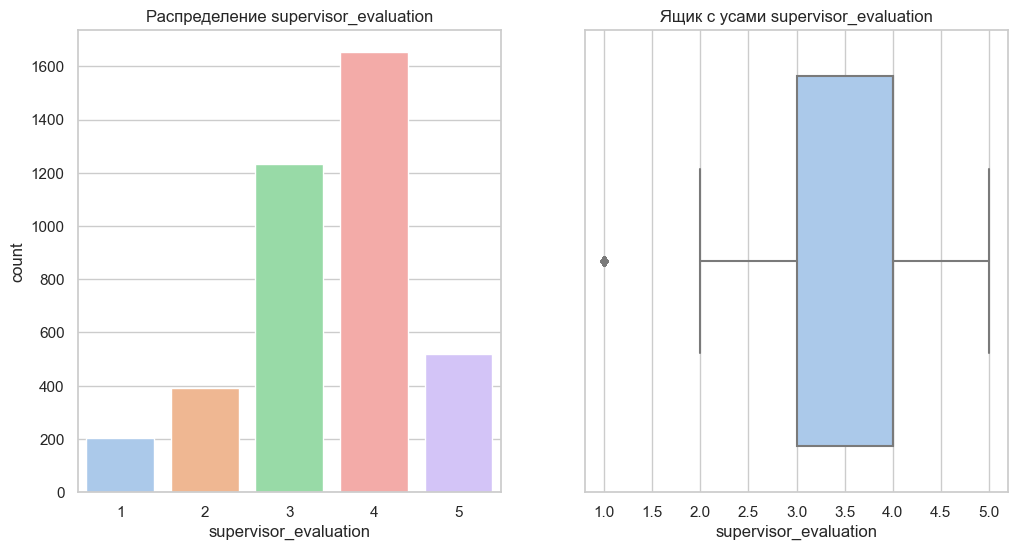

In [74]:
eda_describe_feature(X_train_quit, 'supervisor_evaluation', is_discrete=True)


	Описательная статистика столбца - supervisor_evaluation_segment
count            4000
unique              2
top       more than 4
freq             2174
Name: supervisor_evaluation_segment, dtype: object


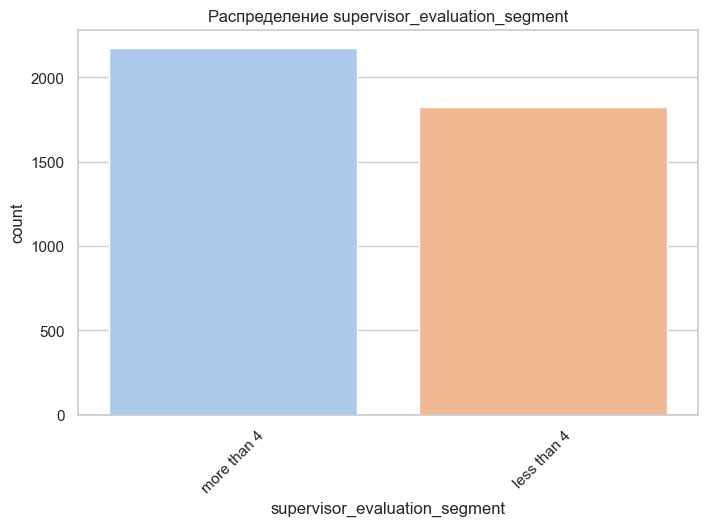

In [75]:
X_train_quit['supervisor_evaluation_segment'] = pd.cut(X_train_quit['supervisor_evaluation'],
                                                    bins=[0, 3.9, 5],
                                                    labels=["less than 4", "more than 4"]).astype(object)
eda_describe_feature(X_train_quit, 'supervisor_evaluation_segment')

##### `salary`


	Описательная статистика столбца - salary
count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


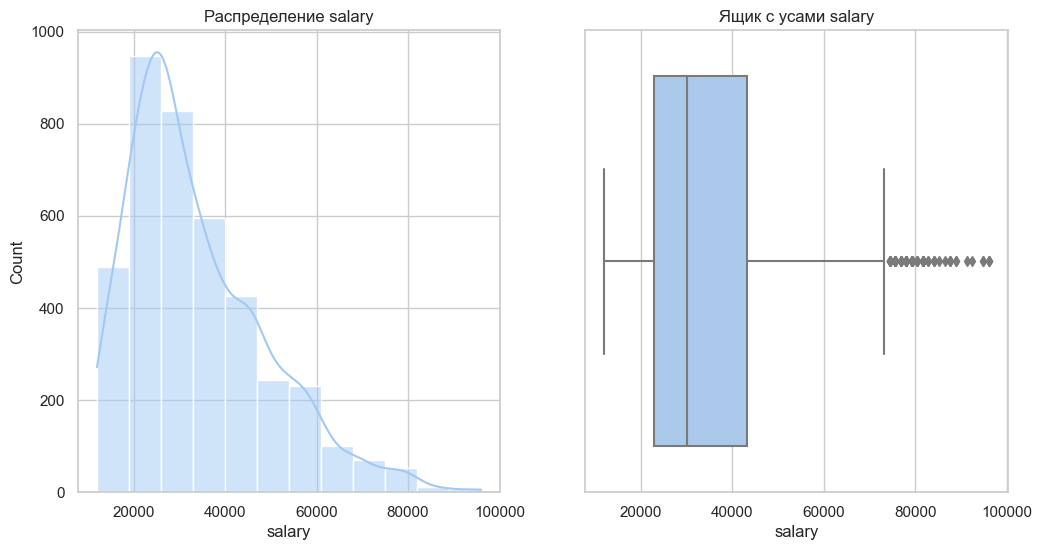

In [76]:
eda_describe_feature(X_train_quit, 'salary')

In [77]:
X_train_quit['salary_log1p'] = np.log1p(X_train_quit['salary'])


	Описательная статистика столбца - salary_log1p
count    4000.000000
mean       10.332693
std         0.438903
min         9.392745
25%        10.034560
50%        10.308986
75%        10.673619
max        11.472114
Name: salary_log1p, dtype: float64


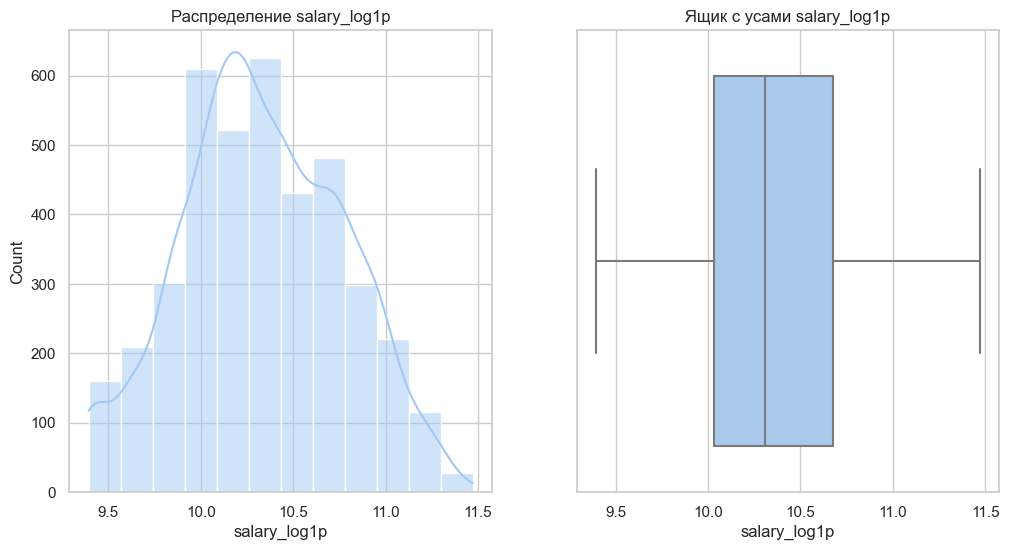

In [78]:
eda_describe_feature(X_train_quit, 'salary_log1p')


	Описательная статистика столбца - quit
count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object


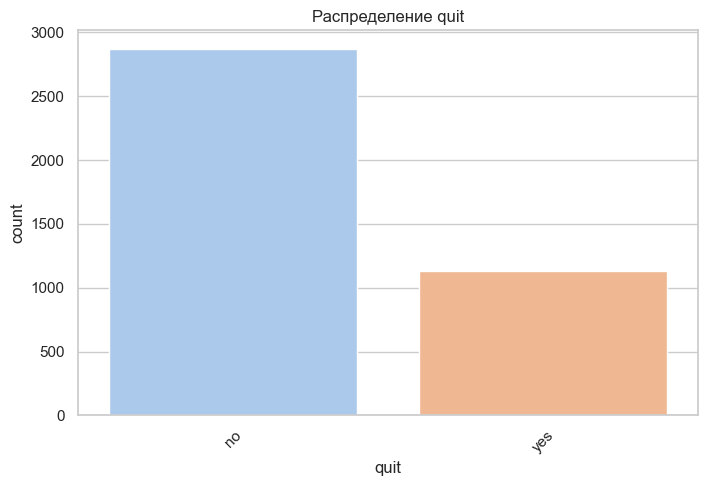

In [79]:
eda_describe_feature(X_train_quit, 'quit')

#### `y_test_quit`


	Описательная статистика столбца - quit
count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object


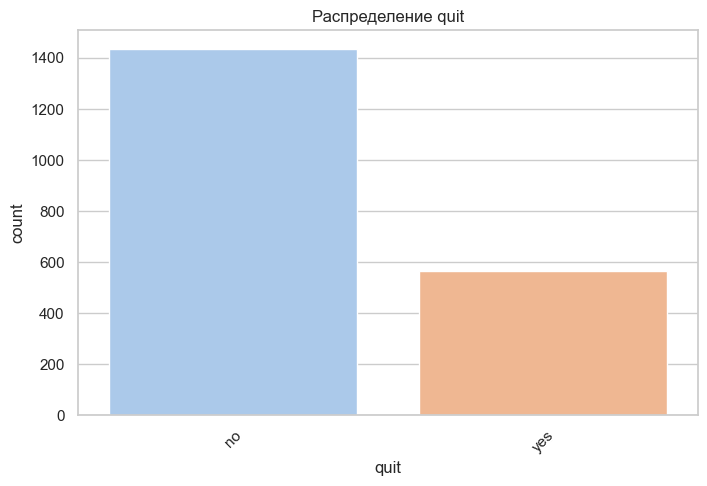

In [80]:
eda_describe_feature(y_test_quit, 'quit')

#### Портрет уволившегося сотрудника

In [81]:
cat_col_names = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
num_col_names = ['employment_years', 'supervisor_evaluation', 'salary']

In [82]:
def check_feature_dependencies(df, feature, target, title="No title"):
    if feature == target:
        return
    if feature in cat_col_names:
        sns.countplot(data=df, x=feature, hue=target)
        plt.title(title + str(feature))
        plt.show()
    elif feature in num_col_names:
        print('\n\t' + title + str(feature) + '\n')
        print(pd.DataFrame(df.groupby(target)[feature].mean()))
    else:
        return

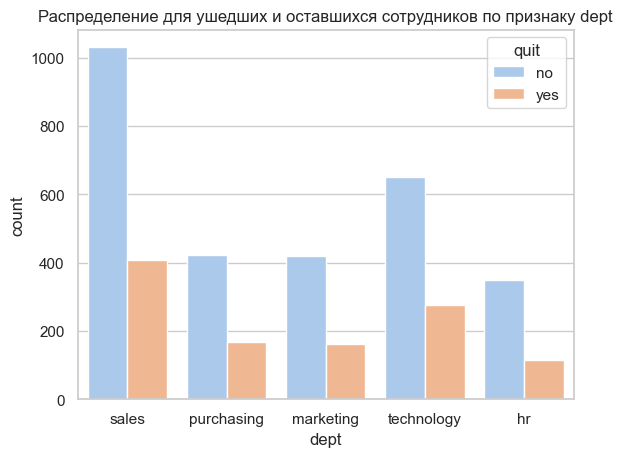

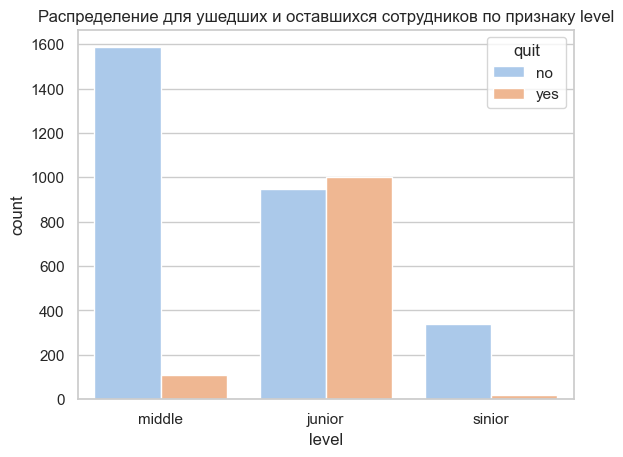

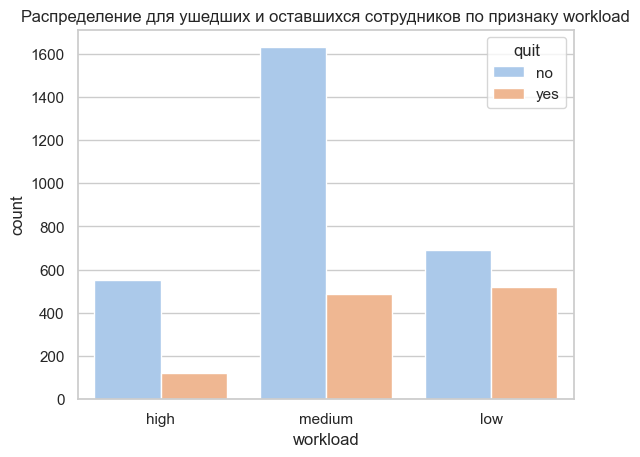


	Распределение для ушедших и оставшихся сотрудников по признаку employment_years

      employment_years
quit                  
no            4.430710
yes           1.844858


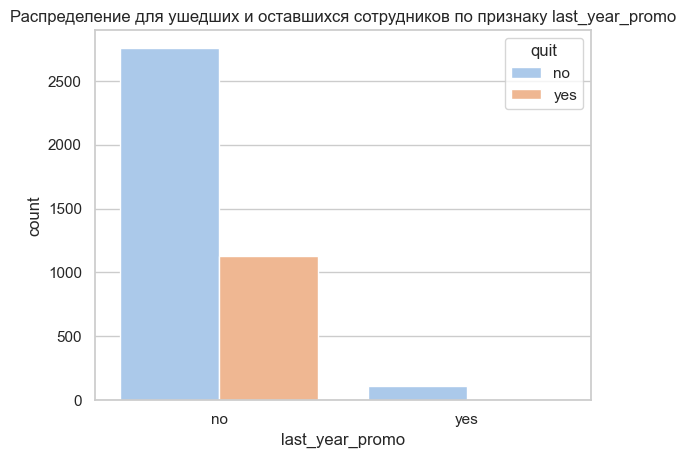

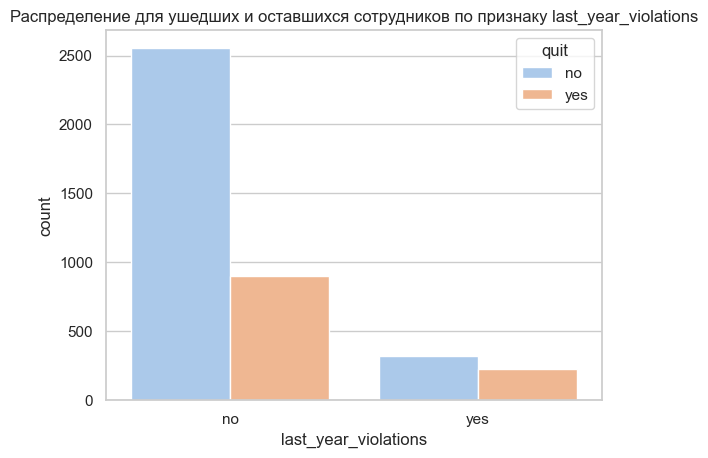


	Распределение для ушедших и оставшихся сотрудников по признаку supervisor_evaluation

      supervisor_evaluation
quit                       
no                 3.643106
yes                3.046099

	Распределение для ушедших и оставшихся сотрудников по признаку salary

            salary
quit              
no    37702.228412
yes   23885.106383


In [83]:
for col in X_train_quit.columns:
    check_feature_dependencies(X_train_quit, col, 'quit', title="Распределение для ушедших и оставшихся сотрудников по признаку ")

**Вывод. Портрет уволившегося сотрудника**

- работает в отделе продаж ("sales")
- уровня "junior"
- работает ~2 года (1.84)
- имеет низкую загруженность
- не получал в предыдущем году повышения
- не нарушал трудовой договор за последний год
- имеет оценку качества работы ~3.05, которую дал руководитель
- получает среднюю зарплату ~24 000 (23885)

Проверка на то, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

In [84]:
X_test_sr_full = X_test_sr.merge(y_test_quit, on='id', how='left').merge(y_test_sr, on='id', how='left')

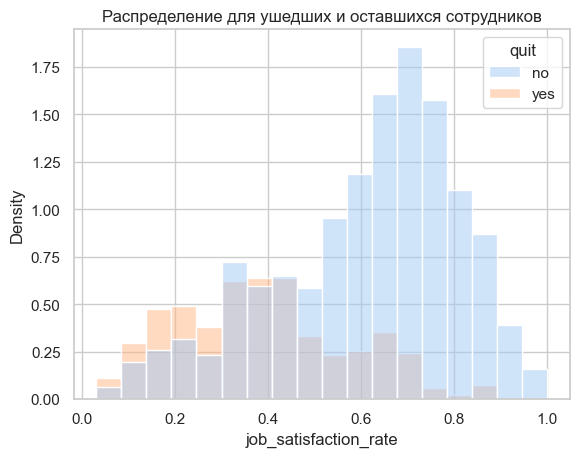

In [85]:
sns.histplot(data=X_test_sr_full, x='job_satisfaction_rate', hue='quit', stat='density')
plt.title('Распределение для ушедших и оставшихся сотрудников')
plt.show()

In [86]:
pd.DataFrame(X_test_sr_full.groupby('quit')['job_satisfaction_rate'].mean())

job_satisfaction_rate
quit                       
no                 0.612040
yes                0.387713

**Вывод**

Утверждение _"уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник"_ **верно**. Большая часть тех кто удовлетворен работой не планирует увольняться.

### Корреляционный анализ

In [87]:
corr_matrix2 = X_train_quit.drop(columns='id').phik_matrix(interval_cols=['salary', 'salary_log1p', 'job_satisfaction_rate'])

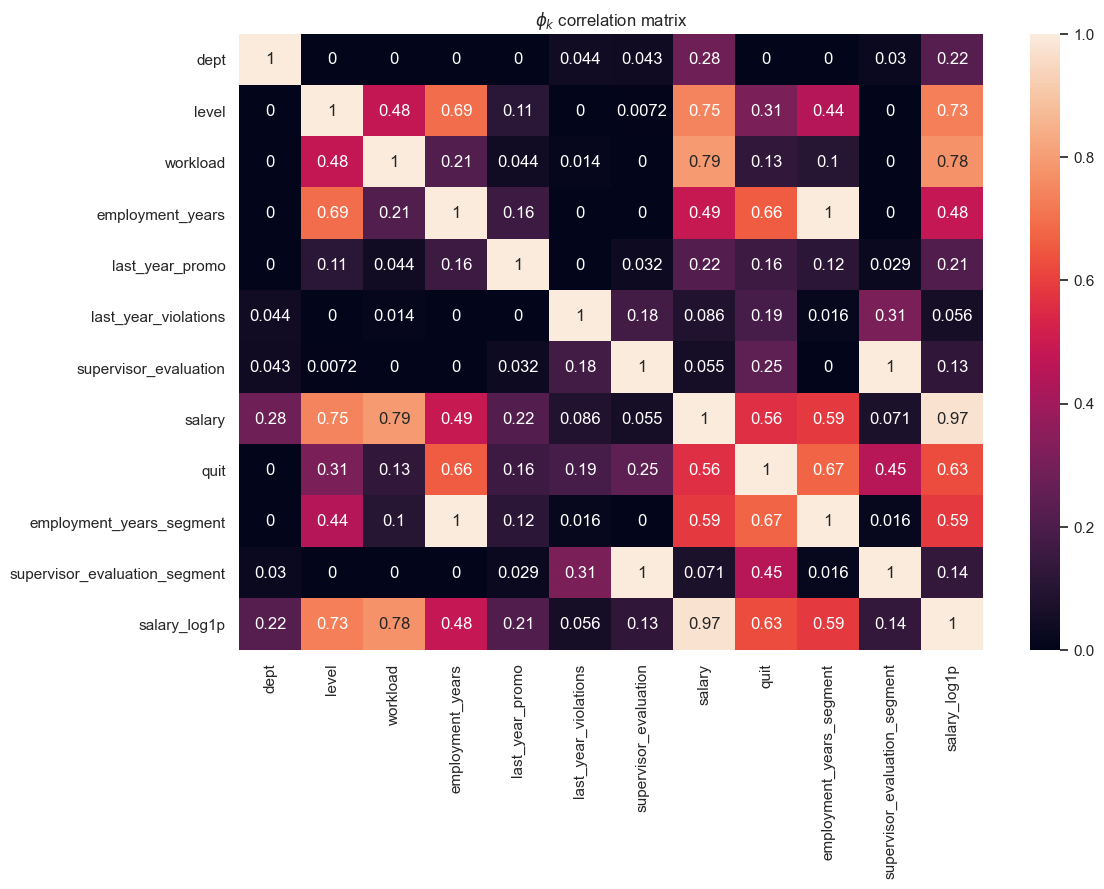

In [88]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix2, annot=True)
plt.title("$\phi_k$ correlation matrix")
plt.show()


	Для категориального признака - `quit`


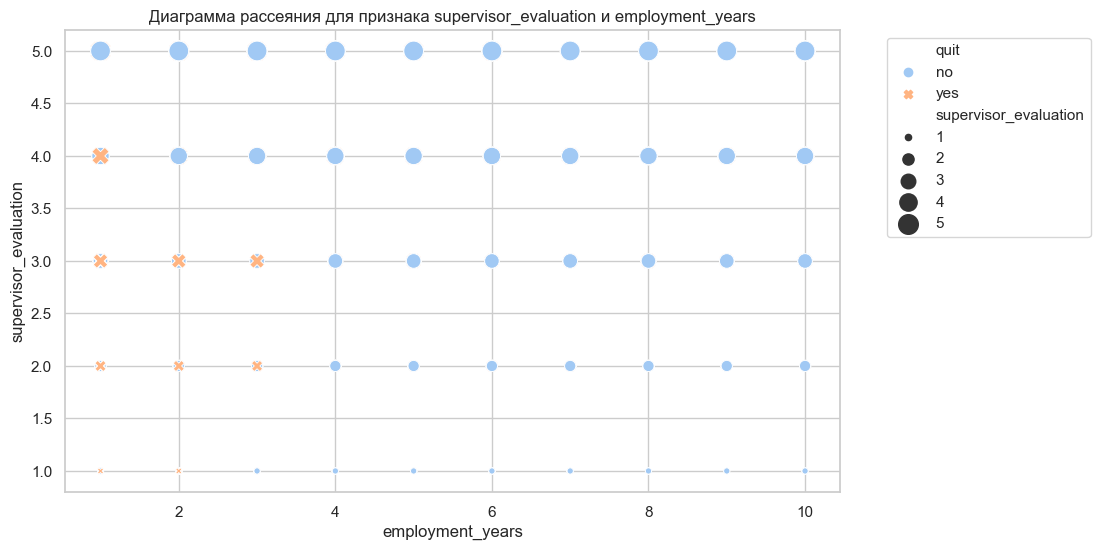

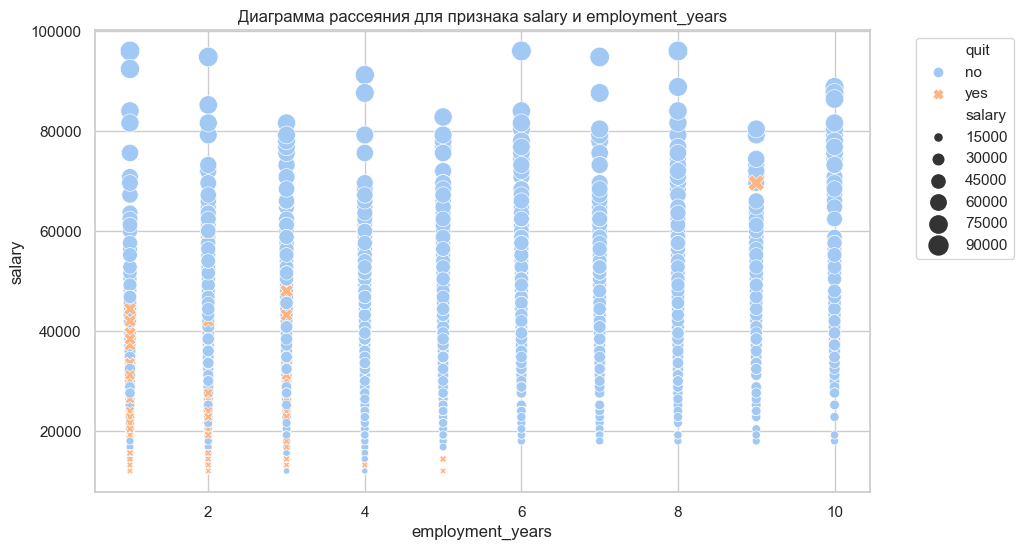

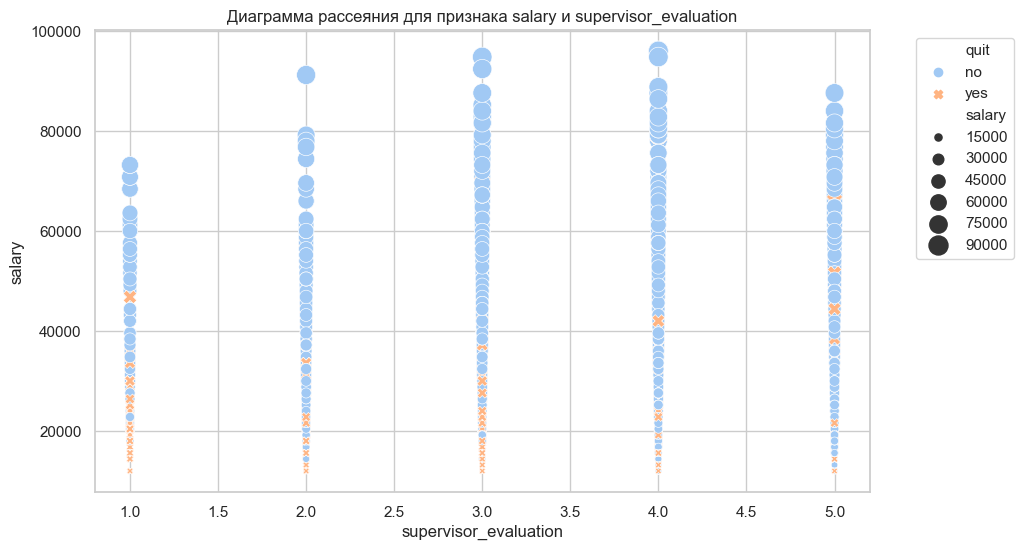

In [89]:
print(f'\n\tДля категориального признака - `quit`')
for num_col_1, num_col_2 in itertools.combinations(num_col_names, 2):
    plot_scatter(X_train_quit, num_col_1, num_col_2, 'quit')

**Выводы**
- Среди сотрудников, работающих недолго (1-3 года), те у кого высоко оценили качество работы, не хотят уходить. Возможно можно пересмотреть оценивание работников с небольшим опытом работы в компании.
- Уровень заработной платы влияет на уход сотрудника, в тех случаях когда он работал в компании меньше 6 лет. Те, кто работают больше, меньше задумываются об уходе. Оценка качества работы почти никак не влияет на то уйдет сотрудник или нет.

### Добавление нового входного признака

In [90]:
X_train_quit['job_satisfaction_rate'] = grid_search.predict(X_train_quit)

### Подготовка данных

In [91]:
X_train = X_train_quit.drop(['id', 'quit'], axis=1)
y_train = X_train_quit['quit']

X_test = X_test_sr_full.drop(['id', 'quit'], axis=1)
y_test = X_test_sr_full['quit']

In [92]:
ord_columns = ['level', 'workload']
ohe_columns = ['last_year_promo', 'last_year_violations', 'employment_years_segment', 'dept', 'supervisor_evaluation_segment']
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [93]:
ohe_pipeline = Pipeline([
    ('replace_blanks', FunctionTransformer(replace_blank_with_nan,
                                           feature_names_out='one-to-one')),
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [94]:
ord_pipeline = Pipeline([
    ('replace_blanks', FunctionTransformer(replace_blank_with_nan,
                                           feature_names_out='one-to-one')),
    ('simpleImputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high'],
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)
    ),
    ('simpleImputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [95]:
num_pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    #('select', SelectKBest(score_func=f_regression, k=5)),
    ('scaler', StandardScaler())
])

In [96]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipeline, ohe_columns),
        ('ord', ord_pipeline, ord_columns),
        ('num', num_pipeline, num_columns)
    ],
    remainder='passthrough',
)

In [97]:
pipe_final_clf = Pipeline([
    ('preprocessor', data_preprocessor),
    #('select', SelectKBest(score_func=f_regression, k=5)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

### Обучение модели

In [98]:
param_grid_clf = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [99]:
grid_search_clf = GridSearchCV(
    pipe_final_clf,
    param_grid_clf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
)
grid_search_clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('replace_blanks',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function replace_blank_with_nan at 0x0000022A4B5A2B80>)),
                                                                                         ('simpleImputer_ohe',
                                                                                          Simple...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [100]:
print('Лучшая модель и её параметры:\n\n', grid_search_clf.best_params_)
print(f'Метрика лучшей модели на тренировочной выборке: {grid_search_clf.best_score_:.2f}')

Лучшая модель и её параметры:

 {'models': KNeighborsClassifier(), 'models__n_neighbors': 8, 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на тренировочной выборке: 0.93


In [101]:
y_pred_proba = grid_search_clf.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba):.2f}')

Метрика ROC-AUC на тестовой выборке: 0.92


### Выводы

На текущем этапе были протестированы несколько моделей, включая `LogisticRegression`, `KNeighborsClassifier` и `DecisionTreeClassifier`. Лучшие результаты по метрике ROC-AUC показала модель `KNeighborsClassifier`, достигнув значения ROC-AUC = 0.92 на тестовой выборке, что удовлетворяет критерию качества.

Основная причина её преимущества — настраиваемый параметр `n_neighbors`. Позволяет выбрать оптимальное количество соседей для более точной классификации. Обычно подбирается через кросс-валидацию.

## Общий вывод

- **Задача 1.** Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- **Задача 2.** Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
- **Основные этапы работы:**
    - Загрузка данных.
    - Предобработка данных. Проверка на дубликаты и пропуски
    - Исследовательский анализ данных. Устранение выбросов, добавление/изменение признаков. Создание портрета "уволившегося сотрудника".
    - Подготовка данных. Настройка пайплайнов для кодирования и устранения пропусков.
    - Обучение моделей. Создание финального пайплайна для подбора гиперпараметров для каждой модели. Использование метрики "SMAPE" для задачи регрессии, "ROC-AUC" - для задачи классификации.
- **Выводы:**
    - Для решения первой задачи подходит модель - `Ridge` с набором параметров \ ({'models__alpha': 1, 'preprocessor__num__scaler': StandardScaler()}).
    - Для решения второй задачи подходит модель - `KNeighborsClassifier` с набором параметров \ ({'models__n_neighbors': 8, 'preprocessor__num': MinMaxScaler()}).
    - Уровень `job_satisfaction_rate` остается разбросанным вне зависимости от количества лет в компании. Даже у сотрудников с 8–10 годами стажа встречаются низкие значения удовлетворённости, как и у новых сотрудников.
    - Чем выше оценка качества работы, тем выше у сотрудника уровень его удовлетворенности в среднем.
    - Низкие оценки руководителей (1–2) почти не приводят к высокой удовлетворенности. Почти отсутствуют крупные точки (высокая удовлетворенность) при низкой `supervisor_evaluation`. Это может говорить о демотивации в подразделениях, где оценивают низко.
    - Во всех департаментах при одинаковой supervisor_evaluation наблюдаются схожие уровни `job_satisfaction_rate` — сильной зависимости от отдела нет.
    - С увеличением зарплаты удовлетворенность работой растет, но эффект более выражен в отделах продаж и технологий.
    - У сотрудников с высокой оценкой руководителя (4–5), но низким уровнем удовлетворённости (0–0.4) наблюдаются чаще нарушения (крестики). Это может говорить о скрытом напряжении: формально всё хорошо, но сотрудники не довольны, что проявляется в поведении.
    - Большинство сотрудников, которые нарушали трудовой договор меньше удовлетворены работой, чем те кто не нарушал, даже вне зависимости от получаемой зарплаты.
- **Дополнительные предложения для бизнеса:**
    - Низкие оценки руководителей (1–2) почти не приводят к высокой удовлетворенности. Почти отсутствуют крупные точки (высокая удовлетворенность) при низкой `supervisor_evaluation`. Это может говорить о демотивации в подразделениях, где оценивают низко.
    - Повышение позитивно влияет на уровень удовлетворенности. У тех кого повысили уровень `job_satisfaction_rate` выше, чем у остальных.
    - Среди сотрудников, работающих недолго (1-3 года), те у кого высоко оценили качество работы, не хотят уходить. Возможно можно пересмотреть оценивание работников с небольшим опытом работы в компании.
    - Уровень заработной платы влияет на уход сотрудника, в тех случаях когда он работал в компании меньше 6 лет. Те, кто работают больше, меньше задумываются об уходе. Оценка качества работы почти никак не влияет на то уйдет сотрудник или нет. Возможно стоит рассмотреть какие-нибудь бонусы для новых сотрудников.